In [1]:
import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import h5py as h5

#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#print("Accelerator type = ",accelerator)
#print("Pytorch verision: ", torch.__version__)

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install ipython-autotime

#%load_ext autotime

In [3]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [2]:
class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [3]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers

In [4]:
tqdm = partial(tqdm, position=0, leave=True)

In [5]:
files_all=[]
for file in os.listdir("/content/drive/MyDrive/geotagged-images"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/MyDrive/geotagged-images/'

#centre_file = folder_path + files_all[50]
left_files_path_rev = []
right_files_path = []


#Change this according to your dataset split

for file in files_all[:61]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[60:120]:
  right_files_path.append(folder_path + file)

In [6]:
print(len(files_all))

297


In [7]:
from multiprocessing import Pool

In [8]:
import multiprocessing
print(multiprocessing.cpu_count())


2


In [9]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.75, fy=0.75, interpolation = cv2.INTER_CUBIC )
  images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.75,fy=0.75, interpolation = cv2.INTER_CUBIC )
  images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)

100%|██████████| 60/60 [00:56<00:00,  1.06it/s]


In [10]:
Dataset = 'Small Village Dataset'

In [11]:
f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left_bgr + images_right_bgr)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_bgr_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 58.709275007247925 [s] ... size 3251.738624 MB


In [ ]:
'''f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left + images_right)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_gray_{Dataset}.h5')/1.e6,'MB')

In [12]:
del images_left_bgr,images_right_bgr

In [ ]:
#images_left_bgr_no_enhance = []
#images_right_bgr_no_enhance = []

#for file in tqdm(left_files_path):
#  left_image_sat= cv2.imread(file)
#  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_left_bgr_no_enhance.append(left_img)

#for file in tqdm(right_files_path):
# right_image_sat= cv2.imread(file)
#  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_right_bgr_no_enhance.append(right_img)

In [13]:
from timeit import default_timer as timer

In [14]:
time_all = []

In [15]:
num_kps_sift = []
num_kps_brisk = []
num_kps_agast = []
num_kps_kaze = []
num_kps_akaze = []
num_kps_orb = []
num_kps_mser = []
num_kps_daisy = []
num_kps_surfsift = []
num_kps_fast = []
num_kps_freak = []
num_kps_gftt = []
num_kps_star = []
num_kps_surf = []
num_kps_rootsift = []
num_kps_superpoint = []


In [16]:
images_left_bgr=[]
images_right_bgr=[]

BRISK

In [ ]:
'''
Threshl=60;
Octaves=6; 
#PatternScales=1.0f;

start = timer()

brisk = cv2.BRISK_create(Threshl,Octaves)


keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk=[]

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_left_brisk.append(kpt)
  descriptors_all_left_brisk.append(descrip)
  #points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_right_brisk.append(kpt)
  descriptors_all_right_brisk.append(descrip)
  #points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:33<00:00,  1.80it/s]


In [ ]:
'''for j in tqdm(keypoints_all_left_brisk + keypoints_all_right_brisk[1:]):
  num_kps_brisk.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 378149.12it/s]


In [ ]:
'''all_feat_brisk_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_brisk):
  all_feat_brisk_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_left_each.append(temp)
  all_feat_brisk_left.append(all_feat_brisk_left_each)

In [ ]:
'''all_feat_brisk_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_brisk):
  all_feat_brisk_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_right_each.append(temp)
  all_feat_brisk_right.append(all_feat_brisk_right_each)

In [ ]:
'''del keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk

In [ ]:
'''import pickle
Fdb = open('all_feat_brisk_left.dat', 'wb')
pickle.dump(all_feat_brisk_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_brisk_right.dat', 'wb')
pickle.dump(all_feat_brisk_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_brisk_left, all_feat_brisk_right

ORB

In [ ]:
'''orb = cv2.ORB_create(20000)

start = timer()


keypoints_all_left_orb = []
descriptors_all_left_orb = []
points_all_left_orb=[]

keypoints_all_right_orb = []
descriptors_all_right_orb = []
points_all_right_orb=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()    
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_left_orb.append(kpt)
  descriptors_all_left_orb.append(descrip)
  #points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_right_orb.append(kpt)
  descriptors_all_right_orb.append(descrip)
  #points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:13<00:00,  4.48it/s]


In [ ]:
'''for j in tqdm(keypoints_all_left_orb + keypoints_all_right_orb[1:]):
  num_kps_orb.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 160342.94it/s]


In [ ]:
'''all_feat_orb_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_orb):
  all_feat_orb_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_left_each.append(temp)
  all_feat_orb_left.append(all_feat_orb_left_each)

In [ ]:
'''all_feat_orb_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_orb):
  all_feat_orb_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_right_each.append(temp)
  all_feat_orb_right.append(all_feat_orb_right_each)

In [ ]:
'''del keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb

In [ ]:
'''import pickle
Fdb = open('all_feat_orb_left.dat', 'wb')
pickle.dump(all_feat_orb_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_orb_right.dat', 'wb')
pickle.dump(all_feat_orb_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_orb_left, all_feat_orb_right

KAZE


In [ ]:
'''start = timer()

kaze = cv2.KAZE_create()


keypoints_all_left_kaze = []
descriptors_all_left_kaze = []
points_all_left_kaze=[]

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []
points_all_right_kaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_left_kaze.append(kpt)
  descriptors_all_left_kaze.append(descrip)
  #points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_right_kaze.append(kpt)
  descriptors_all_right_kaze.append(descrip)
  #points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [06:16<00:00,  6.27s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_kaze + keypoints_all_right_kaze[1:]):
  num_kps_kaze.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 315756.89it/s]


In [ ]:
'''all_feat_kaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_kaze):
  all_feat_kaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_left_each.append(temp)
  all_feat_kaze_left.append(all_feat_kaze_left_each)

In [ ]:
'''all_feat_kaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_kaze):
  all_feat_kaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_right_each.append(temp)
  all_feat_kaze_right.append(all_feat_kaze_right_each)

In [ ]:
'''del keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze

In [ ]:
'''import pickle
Fdb = open('all_feat_kaze_left.dat', 'wb')
pickle.dump(all_feat_kaze_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_kaze_right.dat', 'wb')
pickle.dump(all_feat_kaze_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_kaze_left, all_feat_kaze_right

AKAZE

In [ ]:
'''from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
'''start = timer()

akaze = cv2.AKAZE_create()


keypoints_all_left_akaze = []
descriptors_all_left_akaze = []
points_all_left_akaze=[]

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []
points_all_right_akaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = akaze.detect(imgs,None)
  kpt,descrip =  akaze.compute(imgs, kpt)
  keypoints_all_left_akaze.append(kpt)
  descriptors_all_left_akaze.append(descrip)
  #points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = akaze.detect(imgs,None)
  kpt,descrip = akaze.compute(imgs, kpt)
  keypoints_all_right_akaze.append(kpt)
  descriptors_all_right_akaze.append(descrip)
  #points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:02<00:00,  1.04s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_akaze + keypoints_all_right_akaze[1:]):
  num_kps_akaze.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 145341.17it/s]


In [ ]:
'''all_feat_akaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_akaze):
  all_feat_akaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_left_each.append(temp)
  all_feat_akaze_left.append(all_feat_akaze_left_each)

In [ ]:
'''all_feat_akaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_akaze):
  all_feat_akaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_right_each.append(temp)
  all_feat_akaze_right.append(all_feat_akaze_right_each)

In [ ]:
'''del keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze

In [ ]:
'''import pickle
Fdb = open('all_feat_akaze_left.dat', 'wb')
pickle.dump(all_feat_akaze_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_akaze_right.dat', 'wb')
pickle.dump(all_feat_akaze_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_akaze_left, all_feat_akaze_right


STAR + BRIEF

In [ ]:
''''start = timer()

star = cv2.xfeatures2d.StarDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

keypoints_all_left_star = []
descriptors_all_left_brief = []
points_all_left_star=[]

keypoints_all_right_star = []
descriptors_all_right_brief = []
points_all_right_star=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_left_star.append(kpt)
  descriptors_all_left_brief.append(descrip)
  #points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_right_star.append(kpt)
  descriptors_all_right_brief.append(descrip)
  #points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:09<00:00,  6.28it/s]


In [ ]:
'''for j in tqdm(keypoints_all_left_star + keypoints_all_right_star[1:]):
  num_kps_star.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 95596.67it/s]


In [ ]:
'''all_feat_star_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_star):
  all_feat_star_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_left_each.append(temp)
  all_feat_star_left.append(all_feat_star_left_each)

In [ ]:
'''all_feat_star_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_star):
  all_feat_star_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_right_each.append(temp)
  all_feat_star_right.append(all_feat_star_right_each)

In [ ]:
'''del keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief

In [ ]:
'''import pickle
Fdb = open('all_feat_star_left.dat', 'wb')
pickle.dump(all_feat_star_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_star_right.dat', 'wb')
pickle.dump(all_feat_star_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_star_left, all_feat_star_right


BRISK + FREAK

In [17]:
start = timer()

Threshl=60;
Octaves=6; 
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)

freak = cv2.xfeatures2d.FREAK_create()
keypoints_all_left_freak = []
descriptors_all_left_freak = []
points_all_left_freak=[]

keypoints_all_right_freak = []
descriptors_all_right_freak = []
points_all_right_freak=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = brisk.detect(imgs)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_left_freak.append(kpt)
  descriptors_all_left_freak.append(descrip)
  #points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_right_freak.append(kpt)
  descriptors_all_right_freak.append(descrip)
  #points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:22<00:00,  2.37s/it]


In [18]:
for j in tqdm(keypoints_all_left_freak + keypoints_all_right_freak[1:]):
  num_kps_freak.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 290095.95it/s]


In [ ]:
'''all_feat_freak_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_freak):
  all_feat_freak_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_left_each.append(temp)
  all_feat_freak_left.append(all_feat_freak_left_each)

In [ ]:
'''all_feat_freak_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_freak):
  all_feat_freak_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_right_each.append(temp)
  all_feat_freak_right.append(all_feat_freak_right_each)

In [ ]:
'''del keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak

In [ ]:
'''import pickle
Fdb = open('all_feat_freak_left.dat', 'wb')
pickle.dump(all_feat_freak_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_freak_right.dat', 'wb')
pickle.dump(all_feat_freak_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_freak_left, all_feat_freak_right

MSER + SIFT

In [ ]:
'''
start = timer()

mser = cv2.MSER_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_mser = []
descriptors_all_left_mser = []
points_all_left_mser=[]

keypoints_all_right_mser = []
descriptors_all_right_mser = []
points_all_right_mser=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_mser.append(kpt)
  descriptors_all_left_mser.append(descrip)
  #points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_mser.append(kpt)
  descriptors_all_right_mser.append(descrip)
  #points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_mser + keypoints_all_right_mser[1:]):
  num_kps_mser.append(len(j))

In [ ]:
'''
all_feat_mser_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_mser):
  all_feat_mser_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_left_each.append(temp)
  all_feat_mser_left.append(all_feat_mser_left_each)

In [ ]:
'''
all_feat_mser_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_mser):
  all_feat_mser_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_right_each.append(temp)
  all_feat_mser_right.append(all_feat_mser_right_each)

In [ ]:
'''
del keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'wb')
pickle.dump(all_feat_mser_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'wb')
pickle.dump(all_feat_mser_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_mser_left, all_feat_mser_right

AGAST + SIFT

In [17]:
'''start = timer()

agast = cv2.AgastFeatureDetector_create(threshold = 60)
sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000, contrastThreshold=0.02, edgeThreshold=4)

keypoints_all_left_agast = []
descriptors_all_left_agast = []
points_all_left_agast=[]

keypoints_all_right_agast = []
descriptors_all_right_agast = []
points_all_right_agast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_agast.append(kpt)
  descriptors_all_left_agast.append(descrip)
  #points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_agast.append(kpt)
  descriptors_all_right_agast.append(descrip)
  #points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [03:49<00:00,  3.83s/it]


In [18]:
'''for j in tqdm(keypoints_all_left_agast + keypoints_all_right_agast[1:]):
  num_kps_agast.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 136659.38it/s]


In [ ]:
'''all_feat_agast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_agast):
  all_feat_agast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_left_each.append(temp)
  all_feat_agast_left.append(all_feat_agast_left_each)

In [ ]:
'''all_feat_agast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_agast):
  all_feat_agast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_right_each.append(temp)
  all_feat_agast_right.append(all_feat_agast_right_each)

In [ ]:
'''del keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast

In [ ]:
'''import pickle
Fdb = open('all_feat_agast_left.dat', 'wb')
pickle.dump(all_feat_agast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_agast_left

In [ ]:
''''import pickle
Fdb = open('all_feat_agast_right.dat', 'wb')
pickle.dump(all_feat_agast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_agast_right

FAST + SIFT

In [ ]:
'''
start = timer()


fast = cv2.FastFeatureDetector_create(threshold=40)
sift = cv2.xfeatures2d.SIFT_create(nfeatures = 500, contrastThreshold=0.02, edgeThreshold=4)

keypoints_all_left_fast = []
descriptors_all_left_fast = []
points_all_left_fast=[]

keypoints_all_right_fast = []
descriptors_all_right_fast = []
points_all_right_fast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_fast.append(kpt)
  descriptors_all_left_fast.append(descrip)
  #points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_fast.append(kpt)
  descriptors_all_right_fast.append(descrip)
  #points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

 57%|█████▋    | 34/60 [05:28<05:04, 11.72s/it]

In [ ]:
'''
for j in tqdm(keypoints_all_left_fast + keypoints_all_right_fast[1:]):
  num_kps_fast.append(len(j))

In [ ]:
'''
all_feat_fast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_fast):
  all_feat_fast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_left_each.append(temp)
  all_feat_fast_left.append(all_feat_fast_left_each)

In [ ]:
'''
all_feat_fast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_fast):
  all_feat_fast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_right_each.append(temp)
  all_feat_fast_right.append(all_feat_fast_right_each)

In [ ]:
'''
del keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'wb')
pickle.dump(all_feat_fast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'wb')
pickle.dump(all_feat_fast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_fast_left, all_feat_fast_right

GFTT + SIFT

In [ ]:
'''
start = timer()

gftt = cv2.GFTTDetector_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []
points_all_left_gftt=[]

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []
points_all_right_gftt=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_gftt.append(kpt)
  descriptors_all_left_gftt.append(descrip)
  #points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_gftt.append(kpt)
  descriptors_all_right_gftt.append(descrip)
  #points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_gftt + keypoints_all_right_gftt[1:]):
  num_kps_gftt.append(len(j))

In [ ]:
'''
all_feat_gftt_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_gftt):
  all_feat_gftt_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_left_each.append(temp)
  all_feat_gftt_left.append(all_feat_gftt_left_each)

In [ ]:
'''
all_feat_gftt_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_gftt):
  all_feat_gftt_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_right_each.append(temp)
  all_feat_gftt_right.append(all_feat_gftt_right_each)

In [ ]:
'''
del keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'wb')
pickle.dump(all_feat_gftt_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'wb')
pickle.dump(all_feat_gftt_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_gftt_left, all_feat_gftt_right

DAISY+SIFT

In [ ]:
'''
start = timer()

daisy = cv2.xfeatures2d.DAISY_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []
points_all_left_daisy=[]

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []
points_all_right_daisy=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_left_daisy.append(kpt)
  descriptors_all_left_daisy.append(descrip)
  #points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_right_daisy.append(kpt)
  descriptors_all_right_daisy.append(descrip)
  #points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_daisy + keypoints_all_right_daisy[1:]):
  num_kps_daisy.append(len(j))

In [ ]:
'''
all_feat_daisy_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_daisy):
  all_feat_daisy_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_left_each.append(temp)
  all_feat_daisy_left.append(all_feat_daisy_left_each)

In [ ]:
'''
all_feat_daisy_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_daisy):
  all_feat_daisy_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_right_each.append(temp)
  all_feat_daisy_right.append(all_feat_daisy_right_each)

In [ ]:
'''
del keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'wb')
pickle.dump(all_feat_daisy_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'wb')
pickle.dump(all_feat_daisy_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_daisy_left, all_feat_daisy_right

SURF + SIFT

In [ ]:
'''
start = timer()

surf = cv2.xfeatures2d.SURF_create(upright=1)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []
points_all_left_surfsift=[]

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []
points_all_right_surfsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_surfsift.append(kpt)
  descriptors_all_left_surfsift.append(descrip)
  #points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_surfsift.append(kpt)
  descriptors_all_right_surfsift.append(descrip)
  #points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_surfsift + keypoints_all_right_surfsift[1:]):
  num_kps_surfsift.append(len(j))

In [ ]:
'''
all_feat_surfsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surfsift):
  all_feat_surfsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_left_each.append(temp)
  all_feat_surfsift_left.append(all_feat_surfsift_left_each)

In [ ]:
'''
all_feat_surfsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surfsift):
  all_feat_surfsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_right_each.append(temp)
  all_feat_surfsift_right.append(all_feat_surfsift_right_each)

In [ ]:
'''
del keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'wb')
pickle.dump(all_feat_surfsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'wb')
pickle.dump(all_feat_surfsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surfsift_left, all_feat_surfsift_right

SIFT

In [19]:

print(len(left_files_path))

61


In [20]:

print(len(right_files_path))

60


In [ ]:
# H5 file w/o compression
#t0=time.time()
#f=h5.File('drive/MyDrive/all_images_bgr_sift.h5','r')
#print('HDF5  w/o comp.: data shape =',len(f['data'][0]),time.time()-t0,'[s]')
#f.close()

In [ ]:
#del f

In [21]:

start = timer()

sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000, contrastThreshold=0.02, edgeThreshold=4)
keypoints_all_left_sift = []
descriptors_all_left_sift = []
points_all_left_sift=[]

keypoints_all_right_sift = []
descriptors_all_right_sift = []
points_all_right_sift=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_sift.append(kpt)
  descriptors_all_left_sift.append(descrip)
  #points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_sift.append(kpt)
  descriptors_all_right_sift.append(descrip)
  #points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [05:18<00:00,  5.32s/it]


In [22]:

for j in tqdm(keypoints_all_left_sift + keypoints_all_right_sift[1:]):
  num_kps_sift.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 59283.45it/s]


In [ ]:
'''
all_feat_sift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_sift):
  all_feat_sift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_left_each.append(temp)
  all_feat_sift_left.append(all_feat_sift_left_each)

In [ ]:
'''
all_feat_sift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_sift):
  all_feat_sift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_right_each.append(temp)
  all_feat_sift_right.append(all_feat_sift_right_each)

In [ ]:
'''
del keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'wb')
pickle.dump(all_feat_sift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'wb')
pickle.dump(all_feat_sift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_sift_left, all_feat_sift_right

In [ ]:
#del keypoints_all_right_sift, keypoints_all_left_sift, descriptors_all_right_sift, descriptors_all_left_sift, points_all_right_sift, points_all_left_sift

SURF

In [23]:

start = timer()

surf  = cv2.xfeatures2d.SURF_create(nOctaves = 3, hessianThreshold = 60 ,upright=1)
keypoints_all_left_surf = []
descriptors_all_left_surf = []
points_all_left_surf=[]

keypoints_all_right_surf = []
descriptors_all_right_surf = []
points_all_right_surf=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_left_surf.append(kpt)
  descriptors_all_left_surf.append(descrip)
  #points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_right_surf.append(kpt)
  descriptors_all_right_surf.append(descrip)
  #points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [07:36<00:00,  7.60s/it]


In [24]:

for j in tqdm(keypoints_all_left_surf + keypoints_all_right_surf[1:]):
  num_kps_surf.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 209105.31it/s]


In [ ]:
'''
all_feat_surf_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surf):
  all_feat_surf_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_left_each.append(temp)
  all_feat_surf_left.append(all_feat_surf_left_each)

In [ ]:
'''
all_feat_surf_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surf):
  all_feat_surf_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_right_each.append(temp)
  all_feat_surf_right.append(all_feat_surf_right_each)

In [ ]:
'''
del keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'wb')
pickle.dump(all_feat_surf_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'wb')
pickle.dump(all_feat_surf_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surf_left, all_feat_surf_right

ROOTSIFT

In [ ]:
'''class RootSIFT:
  def __init__(self):
    # initialize the SIFT feature extractor
    #self.extractor = cv2.DescriptorExtractor_create("SIFT")
    self.sift = cv2.xfeatures2d.SIFT_create()

  def compute(self, image, kps, eps=1e-7):
    # compute SIFT descriptors
    (kps, descs) = self.sift.compute(image, kps)

    # if there are no keypoints or descriptors, return an empty tuple
    if len(kps) == 0:
      return ([], None)

    # apply the Hellinger kernel by first L1-normalizing, taking the
    # square-root, and then L2-normalizing
    descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)
    descs /= (descs.sum(axis=0) + eps)
    descs = np.sqrt(descs)
    #descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)

    # return a tuple of the keypoints and descriptors
    return (kps, descs)

In [ ]:
'''start = timer()

sift = cv2.xfeatures2d.SIFT_create()
rootsift = RootSIFT()
keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []
points_all_left_rootsift=[]

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []
points_all_right_rootsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_left_rootsift.append(kpt)
  descriptors_all_left_rootsift.append(descrip)
  #points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_right_rootsift.append(kpt)
  descriptors_all_right_rootsift.append(descrip)
  #points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:08<00:00,  2.14s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_rootsift + keypoints_all_right_rootsift[1:]):
  num_kps_rootsift.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 49388.33it/s]


In [ ]:
'''all_feat_rootsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_rootsift):
  all_feat_rootsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_left_each.append(temp)
  all_feat_rootsift_left.append(all_feat_rootsift_left_each)

In [ ]:
'''all_feat_rootsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_rootsift):
  all_feat_rootsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_right_each.append(temp)
  all_feat_rootsift_right.append(all_feat_rootsift_right_each)

In [ ]:
'''del keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift

In [ ]:
'''import pickle
Fdb = open('all_feat_rootsift_left.dat', 'wb')
pickle.dump(all_feat_rootsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_rootsift_right.dat', 'wb')
pickle.dump(all_feat_rootsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_rootsift_left, all_feat_rootsift_right

SuperPoint

In [ ]:
'''
!git clone https://github.com/magicleap/SuperPointPretrainedNetwork.git

In [ ]:
'''
weights_path = 'SuperPointPretrainedNetwork/superpoint_v1.pth'

cuda = 'True'

In [ ]:
'''
def to_kpts(pts, size=1):
  return [cv2.KeyPoint(pt[0], pt[1], size) for pt in pts]

In [ ]:
'''
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.cuda.empty_cache()

class SuperPointNet(nn.Module):
    def __init__(self):
        super(SuperPointNet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        # Shared Encoder.
        self.conv1a = nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
        # Detector Head.
        self.convPa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
        # Descriptor Head.
        self.convDa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

        # Shared Encoder.
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        # Detector Head.
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)
        # Descriptor Head.
        cDa = self.relu(self.convDa(x))
        desc = self.convDb(cDa)
        dn = torch.norm(desc, p=2, dim=1) # Compute the norm.
        desc = desc.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
        return semi, desc


class SuperPointFrontend(object):
    def __init__(self, weights_path, nms_dist, conf_thresh, nn_thresh,cuda=True):
        self.name = 'SuperPoint'
        self.cuda = cuda
        self.nms_dist = nms_dist
        self.conf_thresh = conf_thresh
        self.nn_thresh = nn_thresh # L2 descriptor distance for good match.
        self.cell = 8 # Size of each output cell. Keep this fixed.
        self.border_remove = 4 # Remove points this close to the border.

        # Load the network in inference mode.
        self.net = SuperPointNet()
        if cuda:
          # Train on GPU, deploy on GPU.
            self.net.load_state_dict(torch.load(weights_path))
            self.net = self.net.cuda()
        else:
          # Train on GPU, deploy on CPU.
            self.net.load_state_dict(torch.load(weights_path, map_location=lambda storage, loc: storage))
        self.net.eval()

    def nms_fast(self, in_corners, H, W, dist_thresh):

        grid = np.zeros((H, W)).astype(int) # Track NMS data.
        inds = np.zeros((H, W)).astype(int) # Store indices of points.
        # Sort by confidence and round to nearest int.
        inds1 = np.argsort(-in_corners[2,:])
        corners = in_corners[:,inds1]
        rcorners = corners[:2,:].round().astype(int) # Rounded corners.
        # Check for edge case of 0 or 1 corners.
        if rcorners.shape[1] == 0:
            return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
        if rcorners.shape[1] == 1:
            out = np.vstack((rcorners, in_corners[2])).reshape(3,1)
            return out, np.zeros((1)).astype(int)
        # Initialize the grid.
        for i, rc in enumerate(rcorners.T):
            grid[rcorners[1,i], rcorners[0,i]] = 1
            inds[rcorners[1,i], rcorners[0,i]] = i
        # Pad the border of the grid, so that we can NMS points near the border.
        pad = dist_thresh
        grid = np.pad(grid, ((pad,pad), (pad,pad)), mode='constant')
        # Iterate through points, highest to lowest conf, suppress neighborhood.
        count = 0
        for i, rc in enumerate(rcorners.T):
          # Account for top and left padding.
            pt = (rc[0]+pad, rc[1]+pad)
            if grid[pt[1], pt[0]] == 1: # If not yet suppressed.
                grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1] = 0
                grid[pt[1], pt[0]] = -1
                count += 1
        # Get all surviving -1's and return sorted array of remaining corners.
        keepy, keepx = np.where(grid==-1)
        keepy, keepx = keepy - pad, keepx - pad
        inds_keep = inds[keepy, keepx]
        out = corners[:, inds_keep]
        values = out[-1, :]
        inds2 = np.argsort(-values)
        out = out[:, inds2]
        out_inds = inds1[inds_keep[inds2]]
        return out, out_inds

    def run(self, img):
        assert img.ndim == 2 #Image must be grayscale.
        assert img.dtype == np.float32 #Image must be float32.
        H, W = img.shape[0], img.shape[1]
        inp = img.copy()
        inp = (inp.reshape(1, H, W))
        inp = torch.from_numpy(inp)
        inp = torch.autograd.Variable(inp).view(1, 1, H, W)
        if self.cuda:
            inp = inp.cuda()
        # Forward pass of network.
        outs = self.net.forward(inp)
        semi, coarse_desc = outs[0], outs[1]
        # Convert pytorch -> numpy.
        semi = semi.data.cpu().numpy().squeeze()
        
        # --- Process points.
        dense = np.exp(semi) # Softmax.
        dense = dense / (np.sum(dense, axis=0)+.00001) # Should sum to 1.
        nodust = dense[:-1, :, :]
        # Reshape to get full resolution heatmap.
        Hc = int(H / self.cell)
        Wc = int(W / self.cell)
        nodust = np.transpose(nodust, [1, 2, 0])
        heatmap = np.reshape(nodust, [Hc, Wc, self.cell, self.cell])
        heatmap = np.transpose(heatmap, [0, 2, 1, 3])
        heatmap = np.reshape(heatmap, [Hc*self.cell, Wc*self.cell]) 
        prob_map = heatmap/np.sum(np.sum(heatmap))
        
        return heatmap, coarse_desc


    def key_pt_sampling(self, img, heat_map, coarse_desc, sampled):
        
        H, W = img.shape[0], img.shape[1]

        xs, ys = np.where(heat_map >= self.conf_thresh) # Confidence threshold.
        if len(xs) == 0:
            return np.zeros((3, 0)), None, None
        print("number of pts selected :", len(xs))
        
        
        pts = np.zeros((3, len(xs))) # Populate point data sized 3xN.
        pts[0, :] = ys
        pts[1, :] = xs
        pts[2, :] = heat_map[xs, ys]
        pts, _ = self.nms_fast(pts, H, W, dist_thresh=self.nms_dist) # Apply NMS.
        inds = np.argsort(pts[2,:])
        pts = pts[:,inds[::-1]] # Sort by confidence.
        bord = self.border_remove
        toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W-bord))
        toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H-bord))
        toremove = np.logical_or(toremoveW, toremoveH)
        pts = pts[:, ~toremove]
        pts = pts[:,0:sampled] #we take 2000 keypoints with highest probability from heatmap for our benchmark
        
        # --- Process descriptor.
        D = coarse_desc.shape[1]
        if pts.shape[1] == 0:
            desc = np.zeros((D, 0))
        else:
          # Interpolate into descriptor map using 2D point locations.
            samp_pts = torch.from_numpy(pts[:2, :].copy())
            samp_pts[0, :] = (samp_pts[0, :] / (float(W)/2.)) - 1.
            samp_pts[1, :] = (samp_pts[1, :] / (float(H)/2.)) - 1.
            samp_pts = samp_pts.transpose(0, 1).contiguous()
            samp_pts = samp_pts.view(1, 1, -1, 2)
            samp_pts = samp_pts.float()
            if self.cuda:
                samp_pts = samp_pts.cuda()            
            desc = nn.functional.grid_sample(coarse_desc, samp_pts)
            desc = desc.data.cpu().numpy().reshape(D, -1)
            desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]

            
        return pts, desc

In [ ]:
'''
print('Loading pre-trained network.')
# This class runs the SuperPoint network and processes its outputs.
fe = SuperPointFrontend(weights_path=weights_path,nms_dist = 3,conf_thresh = 0.01,nn_thresh=0.5)
print('Successfully loaded pre-trained network.')

In [ ]:
'''
start = timer()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []
points_all_left_superpoint=[]

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []
points_all_right_superpoint=[]

tqdm = partial(tqdm, position=0, leave=True)

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  lfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(lfpth)
  pts_1, desc_1 = fe.key_pt_sampling(lfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_left_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_left_superpoint.append(desc_1.T)
  #points_all_left_superpoint.append(pts_1.T)


for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  rfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(rfpth)
  pts_1, desc_1 = fe.key_pt_sampling(rfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_right_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_right_superpoint.append(desc_1.T)
  #points_all_right_superpoint.append(pts_1.T)

end = timer()
time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_superpoint + keypoints_all_right_superpoint[1:]):
  num_kps_superpoint.append(len(j))

In [ ]:
'''
all_feat_superpoint_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_superpoint):
  all_feat_superpoint_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_left_each.append(temp)
  all_feat_superpoint_left.append(all_feat_superpoint_left_each)

In [ ]:
'''
all_feat_superpoint_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_superpoint):
  all_feat_superpoint_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_right_each.append(temp)
  all_feat_superpoint_right.append(all_feat_superpoint_right_each)

In [ ]:
'''
del keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'wb')
pickle.dump(all_feat_superpoint_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'wb')
pickle.dump(all_feat_superpoint_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_superpoint_left, all_feat_superpoint_right

Total Matches,Robust Matches and Homography Computation

In [26]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh, maxIters=3000)
    inliers = inliers.flatten()
    return H, inliers

In [27]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [28]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.75,thresh=4,use_lowe=True,disp=False,no_ransac=False,binary=False):
  lff1 = descripts[0]
  lff = descripts[1]

  if use_lowe==False:
    #FLANN_INDEX_KDTREE = 2
    #index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    #search_params = dict(checks=50)
    #flann = cv2.FlannBasedMatcher(index_params, search_params)
    #flann = cv2.BFMatcher()
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    #matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    matches_4 = bf.knnMatch(lff1, lff,k=2)
    matches_lf1_lf = []


    print("\nNumber of matches",len(matches_4))
    '''
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      #if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
      matches_4.append(m[0])
    '''
    print("Number of matches After Lowe's Ratio",len(matches_4))
  else:
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])
    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    #matches_lf1_lf = bf.knnMatch(lff1, lff,k=2)


    print("\nNumber of matches",len(matches_lf1_lf))
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])
  
    print("Number of matches After Lowe's Ratio",len(matches_4))


  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  if no_ransac==True:
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)
  else:
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  

  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  
  if len(inlier_matchset)<25:
    matches_4 = []
    ratio = 0.85
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
  
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [29]:
def get_Hmatrix_rfnet(imgs,pts,descripts,disp=True):

  des1 = descripts[0]
  des2 = descripts[1]

  kp1 = pts[0]
  kp2 = pts[1]


  predict_label, nn_kp2 = nearest_neighbor_distance_ratio_match(des1, des2, kp2, 0.7)
  idx = predict_label.nonzero().view(-1)
  mkp1 = kp1.index_select(dim=0, index=idx.long())  # predict match keypoints in I1
  mkp2 = nn_kp2.index_select(dim=0, index=idx.long())  # predict match keypoints in I2

  #img1, img2 = reverse_img(img1), reverse_img(img2)
  keypoints1 = list(map(to_cv2_kp, mkp1))
  keypoints2 = list(map(to_cv2_kp, mkp2))
  DMatch = list(map(to_cv2_dmatch, np.arange(0, len(keypoints1))))

  imm1_pts=np.empty((len(DMatch),2))
  imm2_pts=np.empty((len(DMatch),2))
  for i in range(0,len(DMatch)):
    m = DMatch[i]
    (a_x, a_y) = keypoints1[m.queryIdx].pt
    (b_x, b_y) = keypoints2[m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography_fast(imm1_pts,imm2_pts) 


  if disp==True:
    dispimg1 = cv2.drawMatches(imgs[0], keypoints1, imgs[1], keypoints2, DMatch, None)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')


  return H/H[2,2]

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_brisk.append(keypoints_each)
  descriptors_all_left_brisk.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_brisk.append(keypoints_each)
  descriptors_all_right_brisk.append(descrip_each)

In [ ]:
'''H_left_brisk = []
H_right_brisk = []

num_matches_brisk = []
num_good_matches_brisk = []

images_left_bgr = []
images_right_bgr = []
for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_brisk[j:j+2][::-1],points_all_left_brisk[j:j+2][::-1],descriptors_all_left_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_left_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_brisk[j:j+2][::-1],points_all_right_brisk[j:j+2][::-1],descriptors_all_right_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_right_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_left_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005538225173950195 [s] ... size 0.006368 MB


In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_right_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005404472351074219 [s] ... size 0.006296 MB


In [ ]:
'''del H_left_brisk, H_right_brisk,keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk, points_all_left_brisk, points_all_right_brisk

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_sift = []
descriptors_all_left_sift = []



for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_sift.append(keypoints_each)
  descriptors_all_left_sift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_sift = []
descriptors_all_right_sift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_sift.append(keypoints_each)
  descriptors_all_right_sift.append(descrip_each)

In [30]:

H_left_sift = []
H_right_sift = []

num_matches_sift = []
num_good_matches_sift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_sift[j:j+2][::-1],points_all_left_sift[j:j+2][::-1],descriptors_all_left_sift[j:j+2][::-1],0.75)
  H_left_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_sift[j:j+2][::-1],points_all_right_sift[j:j+2][::-1],descriptors_all_right_sift[j:j+2][::-1],0.75)
  H_right_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

  2%|▏         | 1/61 [00:00<00:12,  4.75it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 98
Number of Robust matches 31



Number of matches 1000
Number of matches After Lowe's Ratio 118
Number of Robust matches 44




  7%|▋         | 4/61 [00:00<00:09,  6.24it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 110
Number of Robust matches 35



Number of matches 1000
Number of matches After Lowe's Ratio 124
Number of Robust matches 46




 10%|▉         | 6/61 [00:00<00:07,  7.49it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 86
Number of Robust matches 41



Number of matches 1000
Number of matches After Lowe's Ratio 87
Number of Robust matches 42




 13%|█▎        | 8/61 [00:01<00:06,  7.81it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 147
Number of Robust matches 93



Number of matches 1001
Number of matches After Lowe's Ratio 115
Number of Robust matches 45




 16%|█▋        | 10/61 [00:01<00:06,  8.30it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 132
Number of Robust matches 58



Number of matches 1000
Number of matches After Lowe's Ratio 110
Number of Robust matches 45



Number of matches 1000
Number of matches After Lowe's Ratio 99


 20%|█▉        | 12/61 [00:01<00:06,  7.35it/s]

Number of Robust matches 23


Number of matches After Lowe's Ratio New 193
Number of Robust matches New 30



Number of matches 1000
Number of matches After Lowe's Ratio 147
Number of Robust matches 45




 23%|██▎       | 14/61 [00:01<00:06,  7.13it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 32
Number of Robust matches 19


Number of matches After Lowe's Ratio New 78
Number of Robust matches New 27



Number of matches 1000
Number of matches After Lowe's Ratio 9
Number of Robust matches 6


Number of matches After Lowe's Ratio New 51
Number of Robust matches New 7




 26%|██▌       | 16/61 [00:02<00:06,  7.28it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 17
Number of Robust matches 12


Number of matches After Lowe's Ratio New 72
Number of Robust matches New 12



Number of matches 1000
Number of matches After Lowe's Ratio 109
Number of Robust matches 45




 30%|██▉       | 18/61 [00:02<00:05,  7.97it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 95
Number of Robust matches 29



Number of matches 1001
Number of matches After Lowe's Ratio 81
Number of Robust matches 27




 31%|███       | 19/61 [00:02<00:06,  6.75it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 69
Number of Robust matches 18


Number of matches After Lowe's Ratio New 163
Number of Robust matches New 25



Number of matches 1000
Number of matches After Lowe's Ratio 85


 36%|███▌      | 22/61 [00:02<00:04,  8.45it/s]

Number of Robust matches 35



Number of matches 1000
Number of matches After Lowe's Ratio 88
Number of Robust matches 47



Number of matches 1000
Number of matches After Lowe's Ratio 136
Number of Robust matches 100




 39%|███▉      | 24/61 [00:03<00:04,  8.41it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 116
Number of Robust matches 81



Number of matches 1000
Number of matches After Lowe's Ratio 81
Number of Robust matches 30




 41%|████      | 25/61 [00:03<00:04,  8.46it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 62
Number of Robust matches 25



Number of matches 1000
Number of matches After Lowe's Ratio 45
Number of Robust matches 9


Number of matches After Lowe's Ratio New 118


 44%|████▍     | 27/61 [00:03<00:04,  7.00it/s]

Number of Robust matches New 9



Number of matches 1000
Number of matches After Lowe's Ratio 102
Number of Robust matches 26




 46%|████▌     | 28/61 [00:03<00:05,  6.46it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 33
Number of Robust matches 12


Number of matches After Lowe's Ratio New 85
Number of Robust matches New 13



Number of matches 1000
Number of matches After Lowe's Ratio 11
Number of Robust matches 4


Number of matches After Lowe's Ratio New 68


 49%|████▉     | 30/61 [00:04<00:05,  6.18it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 17
Number of Robust matches 9


Number of matches After Lowe's Ratio New 68
Number of Robust matches New 12




 51%|█████     | 31/61 [00:04<00:05,  5.93it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 56
Number of Robust matches 18


Number of matches After Lowe's Ratio New 130
Number of Robust matches New 22



Number of matches 1000
Number of matches After Lowe's Ratio 132


 54%|█████▍    | 33/61 [00:04<00:04,  6.88it/s]

Number of Robust matches 36



Number of matches 1000
Number of matches After Lowe's Ratio 98
Number of Robust matches 31




 57%|█████▋    | 35/61 [00:04<00:03,  6.98it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 78
Number of Robust matches 23


Number of matches After Lowe's Ratio New 168
Number of Robust matches New 33



Number of matches 1000
Number of matches After Lowe's Ratio 94
Number of Robust matches 36




 61%|██████    | 37/61 [00:05<00:03,  7.79it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 85
Number of Robust matches 35



Number of matches 1000
Number of matches After Lowe's Ratio 95
Number of Robust matches 62




 64%|██████▍   | 39/61 [00:05<00:02,  8.02it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 114
Number of Robust matches 64



Number of matches 1000
Number of matches After Lowe's Ratio 142
Number of Robust matches 96




 66%|██████▌   | 40/61 [00:05<00:02,  7.02it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 41
Number of Robust matches 18


Number of matches After Lowe's Ratio New 107
Number of Robust matches New 21



Number of matches 1000
Number of matches After Lowe's Ratio 75
Number of Robust matches 23


Number of matches After Lowe's Ratio New 171


 69%|██████▉   | 42/61 [00:05<00:03,  6.05it/s]

Number of Robust matches New 28



Number of matches 1001
Number of matches After Lowe's Ratio 78
Number of Robust matches 19


Number of matches After Lowe's Ratio New 160
Number of Robust matches New 21




 70%|███████   | 43/61 [00:05<00:02,  6.14it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 52
Number of Robust matches 17


Number of matches After Lowe's Ratio New 108
Number of Robust matches New 25



Number of matches 1000
Number of matches After Lowe's Ratio 19
Number of Robust matches 8


Number of matches After Lowe's Ratio New 50


 74%|███████▍  | 45/61 [00:06<00:02,  5.95it/s]

Number of Robust matches New 12



Number of matches 1000
Number of matches After Lowe's Ratio 3
Number of Robust matches 0


Number of matches After Lowe's Ratio New 48
Number of Robust matches New 7




 77%|███████▋  | 47/61 [00:06<00:02,  6.56it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 8
Number of Robust matches 5


Number of matches After Lowe's Ratio New 51
Number of Robust matches New 8



Number of matches 1000
Number of matches After Lowe's Ratio 18
Number of Robust matches 14


Number of matches After Lowe's Ratio New 69
Number of Robust matches New 25




 79%|███████▊  | 48/61 [00:06<00:01,  6.90it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 58
Number of Robust matches 24


Number of matches After Lowe's Ratio New 154
Number of Robust matches New 46



Number of matches 1000
Number of matches After Lowe's Ratio 60
Number of Robust matches 11


Number of matches After Lowe's Ratio New 148


 82%|████████▏ | 50/61 [00:07<00:01,  6.61it/s]

Number of Robust matches New 13



Number of matches 1002
Number of matches After Lowe's Ratio 75
Number of Robust matches 31




 84%|████████▎ | 51/61 [00:07<00:01,  7.07it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 55
Number of Robust matches 38



Number of matches 1000
Number of matches After Lowe's Ratio 70
Number of Robust matches 43




 89%|████████▊ | 54/61 [00:07<00:00,  7.96it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 76
Number of Robust matches 51



Number of matches 1000
Number of matches After Lowe's Ratio 85
Number of Robust matches 71



Number of matches 1000
Number of matches After Lowe's Ratio 75


 93%|█████████▎| 57/61 [00:07<00:00,  9.00it/s]

Number of Robust matches 61



Number of matches 1000
Number of matches After Lowe's Ratio 78
Number of Robust matches 67



Number of matches 1001
Number of matches After Lowe's Ratio 66
Number of Robust matches 31




 95%|█████████▌| 58/61 [00:08<00:00,  7.16it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 84
Number of Robust matches 21


Number of matches After Lowe's Ratio New 159
Number of Robust matches New 30



Number of matches 1000
Number of matches After Lowe's Ratio 29
Number of Robust matches 19


Number of matches After Lowe's Ratio New 102


  0%|          | 0/60 [00:00<?, ?it/s]

Number of Robust matches New 36



Number of matches 1000
Number of matches After Lowe's Ratio 11
Number of Robust matches 8


Number of matches After Lowe's Ratio New 47
Number of Robust matches New 14




  3%|▎         | 2/60 [00:00<00:07,  8.20it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 76
Number of Robust matches 31



Number of matches 1000
Number of matches After Lowe's Ratio 44
Number of Robust matches 17


Number of matches After Lowe's Ratio New 98
Number of Robust matches New 25




  5%|▌         | 3/60 [00:00<00:07,  7.19it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 60
Number of Robust matches 18


Number of matches After Lowe's Ratio New 124
Number of Robust matches New 27



Number of matches 1000
Number of matches After Lowe's Ratio 74
Number of Robust matches 19


Number of matches After Lowe's Ratio New 149

  8%|▊         | 5/60 [00:00<00:07,  7.02it/s]


Number of Robust matches New 24



Number of matches 1000
Number of matches After Lowe's Ratio 142
Number of Robust matches 51




 12%|█▏        | 7/60 [00:00<00:06,  7.85it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 102
Number of Robust matches 39



Number of matches 1000
Number of matches After Lowe's Ratio 111
Number of Robust matches 44




 15%|█▌        | 9/60 [00:01<00:05,  8.55it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 134
Number of Robust matches 56



Number of matches 1000
Number of matches After Lowe's Ratio 128
Number of Robust matches 64




 18%|█▊        | 11/60 [00:01<00:05,  9.14it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 115
Number of Robust matches 59



Number of matches 1000
Number of matches After Lowe's Ratio 142
Number of Robust matches 86




 22%|██▏       | 13/60 [00:01<00:05,  9.35it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 71
Number of Robust matches 35



Number of matches 1000
Number of matches After Lowe's Ratio 126
Number of Robust matches 75




 25%|██▌       | 15/60 [00:01<00:05,  8.92it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 121
Number of Robust matches 38



Number of matches 1000
Number of matches After Lowe's Ratio 84
Number of Robust matches 33




 28%|██▊       | 17/60 [00:02<00:05,  8.15it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 94
Number of Robust matches 31



Number of matches 1000
Number of matches After Lowe's Ratio 61
Number of Robust matches 23


Number of matches After Lowe's Ratio New 128
Number of Robust matches New 33




 32%|███▏      | 19/60 [00:02<00:05,  8.20it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 81
Number of Robust matches 48



Number of matches 1000
Number of matches After Lowe's Ratio 29
Number of Robust matches 13


Number of matches After Lowe's Ratio New 84
Number of Robust matches New 24




 35%|███▌      | 21/60 [00:02<00:04,  8.49it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 81
Number of Robust matches 37



Number of matches 1001
Number of matches After Lowe's Ratio 117
Number of Robust matches 45




 38%|███▊      | 23/60 [00:02<00:04,  8.66it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 124
Number of Robust matches 47



Number of matches 1001
Number of matches After Lowe's Ratio 140
Number of Robust matches 49




 42%|████▏     | 25/60 [00:03<00:03,  8.90it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 132
Number of Robust matches 66



Number of matches 1001
Number of matches After Lowe's Ratio 100
Number of Robust matches 71



Number of matches 1000
Number of matches After Lowe's Ratio 93


 45%|████▌     | 27/60 [00:03<00:03,  9.32it/s]

Number of Robust matches 59



Number of matches 1000
Number of matches After Lowe's Ratio 109
Number of Robust matches 80



Number of matches 1000
Number of matches After Lowe's Ratio 34
Number of Robust matches 21


Number of matches After Lowe's Ratio New 95


 48%|████▊     | 29/60 [00:03<00:03,  8.65it/s]

Number of Robust matches New 25



Number of matches 1000
Number of matches After Lowe's Ratio 100
Number of Robust matches 50




 52%|█████▏    | 31/60 [00:03<00:03,  8.74it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 140
Number of Robust matches 51



Number of matches 1000
Number of matches After Lowe's Ratio 127
Number of Robust matches 38




 55%|█████▌    | 33/60 [00:03<00:03,  8.73it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 99
Number of Robust matches 35



Number of matches 1000
Number of matches After Lowe's Ratio 133
Number of Robust matches 54




 58%|█████▊    | 35/60 [00:04<00:02,  8.52it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 43
Number of Robust matches 26



Number of matches 1000
Number of matches After Lowe's Ratio 42
Number of Robust matches 18


Number of matches After Lowe's Ratio New 102
Number of Robust matches New 28




 62%|██████▏   | 37/60 [00:04<00:02,  8.79it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 93
Number of Robust matches 37



Number of matches 1000
Number of matches After Lowe's Ratio 105
Number of Robust matches 42




 65%|██████▌   | 39/60 [00:04<00:02,  8.72it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 135
Number of Robust matches 38



Number of matches 1000
Number of matches After Lowe's Ratio 138
Number of Robust matches 51




 67%|██████▋   | 40/60 [00:04<00:02,  8.93it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 128
Number of Robust matches 70



Number of matches 1000
Number of matches After Lowe's Ratio 44
Number of Robust matches 26



Number of matches 1000
Number of matches After Lowe's Ratio 21
Number of Robust matches 11


Number of matches After Lowe's Ratio New 83


 72%|███████▏  | 43/60 [00:05<00:01,  8.71it/s]

Number of Robust matches New 14



Number of matches 1000
Number of matches After Lowe's Ratio 35
Number of Robust matches 23


Number of matches After Lowe's Ratio New 95
Number of Robust matches New 29



Number of matches 1000
Number of matches After Lowe's Ratio 27


 75%|███████▌  | 45/60 [00:05<00:01,  8.46it/s]

Number of Robust matches 19


Number of matches After Lowe's Ratio New 92
Number of Robust matches New 25



Number of matches 1001
Number of matches After Lowe's Ratio 92
Number of Robust matches 53




 78%|███████▊  | 47/60 [00:05<00:01,  8.97it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 109
Number of Robust matches 44



Number of matches 1001
Number of matches After Lowe's Ratio 88
Number of Robust matches 31




 82%|████████▏ | 49/60 [00:05<00:01,  8.51it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 89
Number of Robust matches 30



Number of matches 1000
Number of matches After Lowe's Ratio 42
Number of Robust matches 20


Number of matches After Lowe's Ratio New 107
Number of Robust matches New 31




 85%|████████▌ | 51/60 [00:06<00:01,  8.59it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 73
Number of Robust matches 27



Number of matches 1000
Number of matches After Lowe's Ratio 62
Number of Robust matches 29




 87%|████████▋ | 52/60 [00:06<00:01,  7.40it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 40
Number of Robust matches 17


Number of matches After Lowe's Ratio New 106
Number of Robust matches New 19



Number of matches 1000
Number of matches After Lowe's Ratio 72
Number of Robust matches 19


Number of matches After Lowe's Ratio New 153


 90%|█████████ | 54/60 [00:06<00:00,  7.11it/s]

Number of Robust matches New 24



Number of matches 1000
Number of matches After Lowe's Ratio 118
Number of Robust matches 37




 93%|█████████▎| 56/60 [00:06<00:00,  8.11it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 127
Number of Robust matches 42



Number of matches 1001
Number of matches After Lowe's Ratio 122
Number of Robust matches 62




 97%|█████████▋| 58/60 [00:06<00:00,  8.61it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 91
Number of Robust matches 60



Number of matches 1000
Number of matches After Lowe's Ratio 93
Number of Robust matches 79




 98%|█████████▊| 59/60 [00:07<00:00,  8.36it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 127
Number of Robust matches 97




In [31]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.037111759185791016 [s] ... size 0.006368 MB


In [32]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006475687026977539 [s] ... size 0.006296 MB


In [33]:

del H_left_sift, H_right_sift,keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift, points_all_left_sift, points_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_fast = []
descriptors_all_left_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_fast.append(keypoints_each)
  descriptors_all_left_fast.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_fast = []
descriptors_all_right_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_fast.append(keypoints_each)
  descriptors_all_right_fast.append(descrip_each)

In [ ]:
'''
H_left_fast = []
H_right_fast = []

num_matches_fast = []
num_good_matches_fast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_fast[j:j+2][::-1],points_all_left_fast[j:j+2][::-1],descriptors_all_left_fast[j:j+2][::-1],0.9,6)
  H_left_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_fast[j:j+2][::-1],points_all_right_fast[j:j+2][::-1],descriptors_all_right_fast[j:j+2][::-1],0.9,6)
  H_right_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_fast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004185199737548828 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_fast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008991241455078125 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_fast, H_right_fast,keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast, points_all_left_fast, points_all_right_fast

In [ ]:
'''import pickle
Fdb = open('all_feat_orb_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_orb = []
descriptors_all_left_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_orb.append(keypoints_each)
  descriptors_all_left_orb.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_orb_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_orb = []
descriptors_all_right_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_orb.append(keypoints_each)
  descriptors_all_right_orb.append(descrip_each)

In [ ]:
'''H_left_orb = []
H_right_orb = []

num_matches_orb = []
num_good_matches_orb = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_orb[j:j+2][::-1],points_all_left_orb[j:j+2][::-1],descriptors_all_left_orb[j:j+2][::-1],0.7)
  H_left_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_orb[j:j+2][::-1],points_all_right_orb[j:j+2][::-1],descriptors_all_right_orb[j:j+2][::-1],0.7)
  H_right_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_left_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004562854766845703 [s] ... size 0.006368 MB


In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_right_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004209756851196289 [s] ... size 0.006296 MB


In [ ]:
'''del H_left_orb, H_right_orb,keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb, points_all_left_orb, points_all_right_orb

In [ ]:
'''import pickle
Fdb = open('all_feat_kaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_kaze = []
descriptors_all_left_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_kaze.append(keypoints_each)
  descriptors_all_left_kaze.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_kaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_kaze.append(keypoints_each)
  descriptors_all_right_kaze.append(descrip_each)

In [ ]:
'''H_left_kaze = []
H_right_kaze = []

num_matches_kaze = []
num_good_matches_kaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_kaze[j:j+2][::-1],points_all_left_kaze[j:j+2][::-1],descriptors_all_left_kaze[j:j+2][::-1])
  H_left_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_kaze[j:j+2][::-1],points_all_right_kaze[j:j+2][::-1],descriptors_all_right_kaze[j:j+2][::-1])
  H_right_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_left_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_kaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0051157474517822266 [s] ... size 0.006368 MB


In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_right_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_kaze_40.h5')/1.e6,'MB')


HDF5  w/o comp.: 0.007517576217651367 [s] ... size 0.006296 MB


In [ ]:
'''del H_left_kaze, H_right_kaze,keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze, points_all_left_kaze, points_all_right_kaze

In [ ]:
'''import pickle
Fdb = open('all_feat_akaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_akaze = []
descriptors_all_left_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_akaze.append(keypoints_each)
  descriptors_all_left_akaze.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_akaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_akaze.append(keypoints_each)
  descriptors_all_right_akaze.append(descrip_each)

In [ ]:
'''H_left_akaze = []
H_right_akaze = []

num_matches_akaze = []
num_good_matches_akaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_akaze[j:j+2][::-1],points_all_left_akaze[j:j+2][::-1],descriptors_all_left_akaze[j:j+2][::-1])
  H_left_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_akaze[j:j+2][::-1],points_all_right_akaze[j:j+2][::-1],descriptors_all_right_akaze[j:j+2][::-1])
  H_right_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_left_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0060634613037109375 [s] ... size 0.006368 MB


In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_right_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008934974670410156 [s] ... size 0.006296 MB


In [ ]:
'''del H_left_akaze, H_right_akaze,keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze, points_all_left_akaze, points_all_right_akaze

In [ ]:
'''import pickle
Fdb = open('all_feat_star_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_star = []
descriptors_all_left_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_star.append(keypoints_each)
  descriptors_all_left_brief.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_star_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_star = []
descriptors_all_right_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_star.append(keypoints_each)
  descriptors_all_right_brief.append(descrip_each)

In [ ]:
'''H_left_brief = []
H_right_brief = []

num_matches_briefstar = []
num_good_matches_briefstar = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_star[j:j+2][::-1],points_all_left_star[j:j+2][::-1],descriptors_all_left_brief[j:j+2][::-1])
  H_left_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_star[j:j+2][::-1],points_all_right_star[j:j+2][::-1],descriptors_all_right_brief[j:j+2][::-1])
  H_right_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_left_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006726503372192383 [s] ... size 0.006368 MB


In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_right_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004112958908081055 [s] ... size 0.006296 MB


In [ ]:
'''del H_left_brief, H_right_brief,keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief, points_all_left_star, points_all_right_star

In [ ]:
'''import pickle
Fdb = open('all_feat_agast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_agast = []
descriptors_all_left_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_agast.append(keypoints_each)
  descriptors_all_left_agast.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_agast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_agast = []
descriptors_all_right_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_agast.append(keypoints_each)
  descriptors_all_right_agast.append(descrip_each)

In [ ]:
'''H_left_agast = []
H_right_agast = []

num_matches_agast = []
num_good_matches_agast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_agast[j:j+2][::-1],points_all_left_agast[j:j+2][::-1],descriptors_all_left_agast[j:j+2][::-1],0.85,6)
  H_left_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_agast[j:j+2][::-1],points_all_right_agast[j:j+2][::-1],descriptors_all_right_agast[j:j+2][::-1],0.85,6)
  H_right_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

In [24]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_left_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.03029775619506836 [s] ... size 0.006368 MB


In [25]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_right_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0060443878173828125 [s] ... size 0.006296 MB


In [26]:
'''del H_left_agast, H_right_agast,keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast, points_all_left_agast, points_all_right_agast

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_daisy.append(keypoints_each)
  descriptors_all_left_daisy.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_daisy.append(keypoints_each)
  descriptors_all_right_daisy.append(descrip_each)

In [ ]:
'''
H_left_daisy = []
H_right_daisy = []

num_matches_daisy = []
num_good_matches_daisy = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_daisy[j:j+2][::-1],points_all_left_daisy[j:j+2][::-1],descriptors_all_left_daisy[j:j+2][::-1],0.7,6)
  H_left_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_daisy[j:j+2][::-1],points_all_right_daisy[j:j+2][::-1],descriptors_all_right_daisy[j:j+2][::-1],0.7,6)
  H_right_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006845712661743164 [s] ... size 0.005576 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004180192947387695 [s] ... size 0.005576 MB


In [ ]:
'''
del H_left_daisy, H_right_daisy,keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy, points_all_left_daisy, points_all_right_daisy

In [ ]:
'''import pickle
Fdb = open('all_feat_freak_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_freak = []
descriptors_all_left_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_freak.append(keypoints_each)
  descriptors_all_left_freak.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_freak_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_freak = []
descriptors_all_right_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_freak.append(keypoints_each)
  descriptors_all_right_freak.append(descrip_each)

In [51]:
H_left_freak = []
H_right_freak = []

num_matches_freak = []
num_good_matches_freak = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_freak[j:j+2][::-1],points_all_left_freak[j:j+2][::-1],descriptors_all_left_freak[j:j+2][::-1],0.7,6)
  H_left_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_freak[j:j+2][::-1],points_all_right_freak[j:j+2][::-1],descriptors_all_right_freak[j:j+2][::-1],0.7,6)
  H_right_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

  2%|▏         | 1/61 [00:06<06:52,  6.88s/it]


Number of matches 51835
Number of matches After Lowe's Ratio 522
Number of Robust matches 175




  3%|▎         | 2/61 [00:14<06:51,  6.97s/it]


Number of matches 53280
Number of matches After Lowe's Ratio 706
Number of Robust matches 250




  5%|▍         | 3/61 [00:20<06:34,  6.80s/it]


Number of matches 43540
Number of matches After Lowe's Ratio 545
Number of Robust matches 224




  7%|▋         | 4/61 [00:26<06:16,  6.61s/it]


Number of matches 44421
Number of matches After Lowe's Ratio 643
Number of Robust matches 307




  8%|▊         | 5/61 [00:32<06:04,  6.51s/it]


Number of matches 52543
Number of matches After Lowe's Ratio 361
Number of Robust matches 165




 10%|▉         | 6/61 [00:41<06:40,  7.28s/it]


Number of matches 77582
Number of matches After Lowe's Ratio 1236
Number of Robust matches 949




 11%|█▏        | 7/61 [00:52<07:31,  8.37s/it]


Number of matches 65900
Number of matches After Lowe's Ratio 1694
Number of Robust matches 1255




 13%|█▎        | 8/61 [01:01<07:24,  8.39s/it]


Number of matches 46340
Number of matches After Lowe's Ratio 962
Number of Robust matches 682




 15%|█▍        | 9/61 [01:07<06:40,  7.70s/it]


Number of matches 43899
Number of matches After Lowe's Ratio 719
Number of Robust matches 405




 16%|█▋        | 10/61 [01:13<06:07,  7.21s/it]


Number of matches 46893
Number of matches After Lowe's Ratio 639
Number of Robust matches 325




 18%|█▊        | 11/61 [01:20<05:52,  7.05s/it]


Number of matches 50141
Number of matches After Lowe's Ratio 529
Number of Robust matches 159




 20%|█▉        | 12/61 [01:27<05:46,  7.06s/it]


Number of matches 51107
Number of matches After Lowe's Ratio 675
Number of Robust matches 224




 21%|██▏       | 13/61 [01:39<06:48,  8.52s/it]


Number of matches 110066
Number of matches After Lowe's Ratio 260
Number of Robust matches 64




 23%|██▎       | 14/61 [01:58<09:10, 11.70s/it]


Number of matches 182471
Number of matches After Lowe's Ratio 297
Number of Robust matches 102




 25%|██▍       | 15/61 [02:18<10:52, 14.18s/it]


Number of matches 90549
Number of matches After Lowe's Ratio 393
Number of Robust matches 175




 26%|██▌       | 16/61 [02:29<09:59, 13.32s/it]


Number of matches 60083
Number of matches After Lowe's Ratio 645
Number of Robust matches 234




 28%|██▊       | 17/61 [02:37<08:36, 11.74s/it]


Number of matches 50965
Number of matches After Lowe's Ratio 504
Number of Robust matches 180




 30%|██▉       | 18/61 [02:45<07:30, 10.49s/it]


Number of matches 55692
Number of matches After Lowe's Ratio 415
Number of Robust matches 115




 31%|███       | 19/61 [02:52<06:38,  9.50s/it]


Number of matches 48833
Number of matches After Lowe's Ratio 368
Number of Robust matches 138




 33%|███▎      | 20/61 [02:59<05:56,  8.70s/it]


Number of matches 59046
Number of matches After Lowe's Ratio 291
Number of Robust matches 101




 34%|███▍      | 21/61 [03:09<06:05,  9.13s/it]


Number of matches 82661
Number of matches After Lowe's Ratio 859
Number of Robust matches 638




 36%|███▌      | 22/61 [03:23<06:54, 10.63s/it]


Number of matches 116299
Number of matches After Lowe's Ratio 2249
Number of Robust matches 1829




 38%|███▊      | 23/61 [03:37<07:23, 11.68s/it]


Number of matches 79833
Number of matches After Lowe's Ratio 1063
Number of Robust matches 915




 39%|███▉      | 24/61 [03:47<06:46, 11.00s/it]


Number of matches 47401
Number of matches After Lowe's Ratio 296
Number of Robust matches 119




 41%|████      | 25/61 [03:53<05:46,  9.63s/it]


Number of matches 43476
Number of matches After Lowe's Ratio 311
Number of Robust matches 117




 43%|████▎     | 26/61 [04:00<05:14,  8.98s/it]


Number of matches 58486
Number of matches After Lowe's Ratio 248
Number of Robust matches 62




 44%|████▍     | 27/61 [04:11<05:20,  9.43s/it]


Number of matches 59362
Number of matches After Lowe's Ratio 429
Number of Robust matches 111




 46%|████▌     | 28/61 [04:22<05:25,  9.87s/it]


Number of matches 83235
Number of matches After Lowe's Ratio 213
Number of Robust matches 58




 48%|████▊     | 29/61 [04:38<06:15, 11.73s/it]


Number of matches 121810
Number of matches After Lowe's Ratio 264
Number of Robust matches 82




 49%|████▉     | 30/61 [04:55<06:57, 13.46s/it]


Number of matches 106594
Number of matches After Lowe's Ratio 339
Number of Robust matches 130




 51%|█████     | 31/61 [05:09<06:41, 13.38s/it]


Number of matches 62799
Number of matches After Lowe's Ratio 385
Number of Robust matches 110




 52%|█████▏    | 32/61 [05:16<05:37, 11.63s/it]


Number of matches 37680
Number of matches After Lowe's Ratio 412
Number of Robust matches 139




 54%|█████▍    | 33/61 [05:21<04:31,  9.71s/it]


Number of matches 42107
Number of matches After Lowe's Ratio 410
Number of Robust matches 165




 56%|█████▌    | 34/61 [05:31<04:21,  9.68s/it]


Number of matches 49801
Number of matches After Lowe's Ratio 397
Number of Robust matches 155




 57%|█████▋    | 35/61 [05:40<04:05,  9.44s/it]


Number of matches 63309
Number of matches After Lowe's Ratio 459
Number of Robust matches 181




 59%|█████▉    | 36/61 [05:52<04:13, 10.14s/it]


Number of matches 89856
Number of matches After Lowe's Ratio 769
Number of Robust matches 488




 61%|██████    | 37/61 [06:08<04:46, 11.92s/it]


Number of matches 124803
Number of matches After Lowe's Ratio 1337
Number of Robust matches 911




 62%|██████▏   | 38/61 [06:23<04:56, 12.91s/it]


Number of matches 82522
Number of matches After Lowe's Ratio 1177
Number of Robust matches 847




 64%|██████▍   | 39/61 [06:34<04:29, 12.25s/it]


Number of matches 56734
Number of matches After Lowe's Ratio 524
Number of Robust matches 330




 66%|██████▌   | 40/61 [06:41<03:44, 10.71s/it]


Number of matches 29716
Number of matches After Lowe's Ratio 249
Number of Robust matches 150




 67%|██████▋   | 41/61 [06:44<02:50,  8.54s/it]


Number of matches 28209
Number of matches After Lowe's Ratio 291
Number of Robust matches 115




 69%|██████▉   | 42/61 [06:48<02:16,  7.19s/it]


Number of matches 44543
Number of matches After Lowe's Ratio 412
Number of Robust matches 125




 70%|███████   | 43/61 [06:57<02:17,  7.66s/it]


Number of matches 74271
Number of matches After Lowe's Ratio 439
Number of Robust matches 100




 72%|███████▏  | 44/61 [07:12<02:49,  9.96s/it]


Number of matches 118599
Number of matches After Lowe's Ratio 200
Number of Robust matches 62




 74%|███████▍  | 45/61 [07:32<03:26, 12.93s/it]


Number of matches 192009
Number of matches After Lowe's Ratio 292
Number of Robust matches 112




 75%|███████▌  | 46/61 [07:56<04:03, 16.27s/it]


Number of matches 124739
Number of matches After Lowe's Ratio 202
Number of Robust matches 54




 77%|███████▋  | 47/61 [08:12<03:43, 15.99s/it]


Number of matches 76264
Number of matches After Lowe's Ratio 222
Number of Robust matches 101




 79%|███████▊  | 48/61 [08:21<03:03, 14.15s/it]


Number of matches 50715
Number of matches After Lowe's Ratio 321
Number of Robust matches 122




 80%|████████  | 49/61 [08:27<02:19, 11.60s/it]


Number of matches 26172
Number of matches After Lowe's Ratio 307
Number of Robust matches 105




 82%|████████▏ | 50/61 [08:31<01:41,  9.23s/it]


Number of matches 57810
Number of matches After Lowe's Ratio 323
Number of Robust matches 145




 84%|████████▎ | 51/61 [08:41<01:35,  9.53s/it]


Number of matches 70296
Number of matches After Lowe's Ratio 544
Number of Robust matches 376




 85%|████████▌ | 52/61 [08:54<01:33, 10.44s/it]


Number of matches 103363
Number of matches After Lowe's Ratio 915
Number of Robust matches 739




 87%|████████▋ | 53/61 [09:10<01:37, 12.23s/it]


Number of matches 134409
Number of matches After Lowe's Ratio 1205
Number of Robust matches 917




 89%|████████▊ | 54/61 [09:30<01:41, 14.52s/it]


Number of matches 136392
Number of matches After Lowe's Ratio 1459
Number of Robust matches 1107




 90%|█████████ | 55/61 [09:46<01:30, 15.10s/it]


Number of matches 96852
Number of matches After Lowe's Ratio 724
Number of Robust matches 537




 92%|█████████▏| 56/61 [09:59<01:11, 14.35s/it]


Number of matches 75418
Number of matches After Lowe's Ratio 347
Number of Robust matches 275




 93%|█████████▎| 57/61 [10:08<00:51, 12.91s/it]


Number of matches 51207
Number of matches After Lowe's Ratio 283
Number of Robust matches 146




 95%|█████████▌| 58/61 [10:15<00:33, 11.14s/it]


Number of matches 40015
Number of matches After Lowe's Ratio 218
Number of Robust matches 91




 97%|█████████▋| 59/61 [10:25<00:21, 10.77s/it]


Number of matches 106502
Number of matches After Lowe's Ratio 238
Number of Robust matches 66




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 145761
Number of matches After Lowe's Ratio 221
Number of Robust matches 98




  2%|▏         | 1/60 [00:10<10:28, 10.66s/it]


Number of matches 85092
Number of matches After Lowe's Ratio 539
Number of Robust matches 188




  3%|▎         | 2/60 [00:28<12:25, 12.85s/it]


Number of matches 122056
Number of matches After Lowe's Ratio 421
Number of Robust matches 158




  5%|▌         | 3/60 [00:44<13:07, 13.81s/it]


Number of matches 75624
Number of matches After Lowe's Ratio 254
Number of Robust matches 81




  7%|▋         | 4/60 [00:55<11:56, 12.80s/it]


Number of matches 56598
Number of matches After Lowe's Ratio 300
Number of Robust matches 122




  8%|▊         | 5/60 [01:03<10:33, 11.52s/it]


Number of matches 51363
Number of matches After Lowe's Ratio 588
Number of Robust matches 238




 10%|█         | 6/60 [01:11<09:16, 10.30s/it]


Number of matches 51247
Number of matches After Lowe's Ratio 574
Number of Robust matches 213




 12%|█▏        | 7/60 [01:18<08:26,  9.55s/it]


Number of matches 43922
Number of matches After Lowe's Ratio 692
Number of Robust matches 307




 13%|█▎        | 8/60 [01:25<07:25,  8.56s/it]


Number of matches 37864
Number of matches After Lowe's Ratio 717
Number of Robust matches 379




 15%|█▌        | 9/60 [01:30<06:20,  7.46s/it]


Number of matches 32542
Number of matches After Lowe's Ratio 732
Number of Robust matches 420




 17%|█▋        | 10/60 [01:34<05:27,  6.56s/it]


Number of matches 33577
Number of matches After Lowe's Ratio 832
Number of Robust matches 534




 18%|█▊        | 11/60 [01:38<04:49,  5.91s/it]


Number of matches 36256
Number of matches After Lowe's Ratio 718
Number of Robust matches 508




 20%|██        | 12/60 [01:45<04:46,  5.97s/it]


Number of matches 46022
Number of matches After Lowe's Ratio 666
Number of Robust matches 456




 22%|██▏       | 13/60 [01:51<04:54,  6.26s/it]


Number of matches 48687
Number of matches After Lowe's Ratio 816
Number of Robust matches 471




 23%|██▎       | 14/60 [01:59<05:12,  6.79s/it]


Number of matches 50780
Number of matches After Lowe's Ratio 816
Number of Robust matches 333




 25%|██▌       | 15/60 [02:07<05:11,  6.92s/it]


Number of matches 50705
Number of matches After Lowe's Ratio 517
Number of Robust matches 229




 27%|██▋       | 16/60 [02:13<05:01,  6.86s/it]


Number of matches 45976
Number of matches After Lowe's Ratio 551
Number of Robust matches 295




 28%|██▊       | 17/60 [02:22<05:12,  7.28s/it]


Number of matches 66233
Number of matches After Lowe's Ratio 427
Number of Robust matches 197




 30%|███       | 18/60 [02:33<06:01,  8.61s/it]


Number of matches 78548
Number of matches After Lowe's Ratio 482
Number of Robust matches 206




 32%|███▏      | 19/60 [02:45<06:29,  9.49s/it]


Number of matches 66880
Number of matches After Lowe's Ratio 285
Number of Robust matches 123




 33%|███▎      | 20/60 [02:54<06:11,  9.29s/it]


Number of matches 44616
Number of matches After Lowe's Ratio 361
Number of Robust matches 137




 35%|███▌      | 21/60 [03:01<05:37,  8.66s/it]


Number of matches 61550
Number of matches After Lowe's Ratio 646
Number of Robust matches 304




 37%|███▋      | 22/60 [03:10<05:34,  8.81s/it]


Number of matches 52476
Number of matches After Lowe's Ratio 645
Number of Robust matches 287




 38%|███▊      | 23/60 [03:17<05:09,  8.36s/it]


Number of matches 44841
Number of matches After Lowe's Ratio 631
Number of Robust matches 258




 40%|████      | 24/60 [03:24<04:41,  7.82s/it]


Number of matches 42339
Number of matches After Lowe's Ratio 864
Number of Robust matches 543




 42%|████▏     | 25/60 [03:29<04:04,  6.99s/it]


Number of matches 30536
Number of matches After Lowe's Ratio 1153
Number of Robust matches 852




 43%|████▎     | 26/60 [03:32<03:15,  5.74s/it]


Number of matches 13741
Number of matches After Lowe's Ratio 593
Number of Robust matches 506




 45%|████▌     | 27/60 [03:33<02:24,  4.39s/it]


Number of matches 21655
Number of matches After Lowe's Ratio 357
Number of Robust matches 297




 47%|████▋     | 28/60 [03:36<02:09,  4.03s/it]


Number of matches 53053
Number of matches After Lowe's Ratio 808
Number of Robust matches 516




 48%|████▊     | 29/60 [03:45<02:53,  5.58s/it]


Number of matches 63303
Number of matches After Lowe's Ratio 974
Number of Robust matches 588




 50%|█████     | 30/60 [03:55<03:21,  6.72s/it]


Number of matches 61548
Number of matches After Lowe's Ratio 822
Number of Robust matches 303




 52%|█████▏    | 31/60 [04:04<03:34,  7.40s/it]


Number of matches 60327
Number of matches After Lowe's Ratio 746
Number of Robust matches 324




 53%|█████▎    | 32/60 [04:13<03:40,  7.87s/it]


Number of matches 52371
Number of matches After Lowe's Ratio 554
Number of Robust matches 294




 55%|█████▌    | 33/60 [04:20<03:28,  7.71s/it]


Number of matches 50099
Number of matches After Lowe's Ratio 443
Number of Robust matches 272




 57%|█████▋    | 34/60 [04:32<03:55,  9.07s/it]


Number of matches 106614
Number of matches After Lowe's Ratio 482
Number of Robust matches 257




 58%|█████▊    | 35/60 [04:46<04:21, 10.44s/it]


Number of matches 80369
Number of matches After Lowe's Ratio 385
Number of Robust matches 206




 60%|██████    | 36/60 [04:57<04:12, 10.50s/it]


Number of matches 57944
Number of matches After Lowe's Ratio 343
Number of Robust matches 188




 62%|██████▏   | 37/60 [05:05<03:49,  9.99s/it]


Number of matches 61220
Number of matches After Lowe's Ratio 642
Number of Robust matches 310




 63%|██████▎   | 38/60 [05:16<03:41, 10.06s/it]


Number of matches 64817
Number of matches After Lowe's Ratio 583
Number of Robust matches 247




 65%|██████▌   | 39/60 [05:26<03:35, 10.27s/it]


Number of matches 53458
Number of matches After Lowe's Ratio 706
Number of Robust matches 303




 67%|██████▋   | 40/60 [05:37<03:24, 10.22s/it]


Number of matches 55348
Number of matches After Lowe's Ratio 1116
Number of Robust matches 893




 68%|██████▊   | 41/60 [05:46<03:07,  9.88s/it]


Number of matches 38111
Number of matches After Lowe's Ratio 968
Number of Robust matches 735




 70%|███████   | 42/60 [05:49<02:22,  7.91s/it]


Number of matches 657
Number of matches After Lowe's Ratio 38
Number of Robust matches 32




 72%|███████▏  | 43/60 [05:49<01:35,  5.64s/it]


Number of matches 32206
Number of matches After Lowe's Ratio 84
Number of Robust matches 52




 73%|███████▎  | 44/60 [05:56<01:33,  5.84s/it]


Number of matches 55953
Number of matches After Lowe's Ratio 879
Number of Robust matches 725




 75%|███████▌  | 45/60 [06:07<01:54,  7.61s/it]


Number of matches 66577
Number of matches After Lowe's Ratio 984
Number of Robust matches 659




 77%|███████▋  | 46/60 [06:19<02:05,  8.93s/it]


Number of matches 57988
Number of matches After Lowe's Ratio 686
Number of Robust matches 357




 78%|███████▊  | 47/60 [06:30<02:02,  9.41s/it]


Number of matches 56537
Number of matches After Lowe's Ratio 597
Number of Robust matches 228




 80%|████████  | 48/60 [06:41<01:58,  9.84s/it]


Number of matches 66766
Number of matches After Lowe's Ratio 513
Number of Robust matches 280




 82%|████████▏ | 49/60 [06:51<01:50, 10.07s/it]


Number of matches 44458
Number of matches After Lowe's Ratio 327
Number of Robust matches 209




 83%|████████▎ | 50/60 [07:03<01:43, 10.39s/it]


Number of matches 83269
Number of matches After Lowe's Ratio 446
Number of Robust matches 233




 85%|████████▌ | 51/60 [07:13<01:33, 10.43s/it]


Number of matches 43571
Number of matches After Lowe's Ratio 252
Number of Robust matches 129




 87%|████████▋ | 52/60 [07:22<01:20, 10.11s/it]


Number of matches 71996
Number of matches After Lowe's Ratio 312
Number of Robust matches 104




 88%|████████▊ | 53/60 [07:34<01:12, 10.43s/it]


Number of matches 59504
Number of matches After Lowe's Ratio 497
Number of Robust matches 173




 90%|█████████ | 54/60 [07:44<01:02, 10.38s/it]


Number of matches 58543
Number of matches After Lowe's Ratio 647
Number of Robust matches 255




 92%|█████████▏| 55/60 [07:54<00:50, 10.20s/it]


Number of matches 53008
Number of matches After Lowe's Ratio 567
Number of Robust matches 244




 93%|█████████▎| 56/60 [08:03<00:39,  9.97s/it]


Number of matches 48015
Number of matches After Lowe's Ratio 1025
Number of Robust matches 790




 95%|█████████▌| 57/60 [08:10<00:27,  9.11s/it]


Number of matches 35630
Number of matches After Lowe's Ratio 1197
Number of Robust matches 1075




 97%|█████████▋| 58/60 [08:14<00:14,  7.42s/it]


Number of matches 13174
Number of matches After Lowe's Ratio 697
Number of Robust matches 661




 98%|█████████▊| 59/60 [08:15<00:05,  5.60s/it]


Number of matches 27039
Number of matches After Lowe's Ratio 495
Number of Robust matches 381




In [52]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.011327743530273438 [s] ... size 0.006368 MB


In [53]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008268594741821289 [s] ... size 0.006296 MB


In [54]:
del H_left_freak, H_right_freak,keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak, points_all_left_freak, points_all_right_freak

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surf = []
descriptors_all_left_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surf.append(keypoints_each)
  descriptors_all_left_surf.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surf = []
descriptors_all_right_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surf.append(keypoints_each)
  descriptors_all_right_surf.append(descrip_each)

In [34]:

H_left_surf = []
H_right_surf = []

num_matches_surf = []
num_good_matches_surf = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surf[j:j+2][::-1],points_all_left_surf[j:j+2][::-1],descriptors_all_left_surf[j:j+2][::-1],0.65)
  H_left_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surf[j:j+2][::-1],points_all_right_surf[j:j+2][::-1],descriptors_all_right_surf[j:j+2][::-1],0.65)
  H_right_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

  2%|▏         | 1/61 [00:17<17:23, 17.40s/it]


Number of matches 118919
Number of matches After Lowe's Ratio 4751
Number of Robust matches 1491




  3%|▎         | 2/61 [00:33<16:34, 16.86s/it]


Number of matches 120148
Number of matches After Lowe's Ratio 5453
Number of Robust matches 1422




  5%|▍         | 3/61 [00:47<15:44, 16.28s/it]


Number of matches 109688
Number of matches After Lowe's Ratio 3653
Number of Robust matches 1184




  7%|▋         | 4/61 [01:02<14:59, 15.78s/it]


Number of matches 115632
Number of matches After Lowe's Ratio 2303
Number of Robust matches 961




  8%|▊         | 5/61 [01:17<14:26, 15.48s/it]


Number of matches 115816
Number of matches After Lowe's Ratio 196
Number of Robust matches 42



Number of matches 129125
Number of matches After Lowe's Ratio 74
Number of Robust matches 6


Number of matches After Lowe's Ratio New 8982


 10%|▉         | 6/61 [01:32<14:13, 15.52s/it]

Number of Robust matches New 10




 11%|█▏        | 7/61 [01:49<14:21, 15.95s/it]


Number of matches 121621
Number of matches After Lowe's Ratio 5827
Number of Robust matches 3605




 13%|█▎        | 8/61 [02:05<14:03, 15.91s/it]


Number of matches 116695
Number of matches After Lowe's Ratio 5089
Number of Robust matches 2533



Number of matches 120428
Number of matches After Lowe's Ratio 6327


 15%|█▍        | 9/61 [02:22<13:58, 16.13s/it]

Number of Robust matches 2789




 16%|█▋        | 10/61 [02:37<13:30, 15.89s/it]


Number of matches 114366
Number of matches After Lowe's Ratio 5353
Number of Robust matches 2289




 18%|█▊        | 11/61 [02:52<13:05, 15.71s/it]


Number of matches 119329
Number of matches After Lowe's Ratio 784
Number of Robust matches 136




 20%|█▉        | 12/61 [03:10<13:14, 16.22s/it]


Number of matches 132315
Number of matches After Lowe's Ratio 763
Number of Robust matches 130




 21%|██▏       | 13/61 [03:28<13:28, 16.85s/it]


Number of matches 145288
Number of matches After Lowe's Ratio 181
Number of Robust matches 25



Number of matches 152090
Number of matches After Lowe's Ratio 40
Number of Robust matches 4


Number of matches After Lowe's Ratio New 10012


 23%|██▎       | 14/61 [03:48<13:48, 17.63s/it]

Number of Robust matches New 10




 25%|██▍       | 15/61 [04:08<14:07, 18.41s/it]


Number of matches 134516
Number of matches After Lowe's Ratio 1481
Number of Robust matches 649




 26%|██▌       | 16/61 [04:27<13:56, 18.58s/it]


Number of matches 133738
Number of matches After Lowe's Ratio 375
Number of Robust matches 80



Number of matches 125135
Number of matches After Lowe's Ratio 162
Number of Robust matches 9


Number of matches After Lowe's Ratio New 9180


 28%|██▊       | 17/61 [04:44<13:24, 18.29s/it]

Number of Robust matches New 83



Number of matches 112432
Number of matches After Lowe's Ratio 207
Number of Robust matches 9


Number of matches After Lowe's Ratio New 9165


 30%|██▉       | 18/61 [05:01<12:49, 17.90s/it]

Number of Robust matches New 16



Number of matches 119682
Number of matches After Lowe's Ratio 190
Number of Robust matches 21


Number of matches After Lowe's Ratio New 9279


 31%|███       | 19/61 [05:17<11:56, 17.05s/it]

Number of Robust matches New 19



Number of matches 117917
Number of matches After Lowe's Ratio 145
Number of Robust matches 7


Number of matches After Lowe's Ratio New 9632


 33%|███▎      | 20/61 [05:33<11:28, 16.79s/it]

Number of Robust matches New 23



Number of matches 127742
Number of matches After Lowe's Ratio 87
Number of Robust matches 8


Number of matches After Lowe's Ratio New 9145


 34%|███▍      | 21/61 [05:49<11:01, 16.54s/it]

Number of Robust matches New 18



Number of matches 144139
Number of matches After Lowe's Ratio 98
Number of Robust matches 6


Number of matches After Lowe's Ratio New 10274


 36%|███▌      | 22/61 [06:06<10:59, 16.91s/it]

Number of Robust matches New 24



Number of matches 137077
Number of matches After Lowe's Ratio 94
Number of Robust matches 10


Number of matches After Lowe's Ratio New 9373


 38%|███▊      | 23/61 [06:25<11:06, 17.54s/it]

Number of Robust matches New 63



Number of matches 128278
Number of matches After Lowe's Ratio 193
Number of Robust matches 19


Number of matches After Lowe's Ratio New 9799


 39%|███▉      | 24/61 [06:44<10:56, 17.73s/it]

Number of Robust matches New 44



Number of matches 118010
Number of matches After Lowe's Ratio 192
Number of Robust matches 11


Number of matches After Lowe's Ratio New 9297


 41%|████      | 25/61 [07:00<10:26, 17.39s/it]

Number of Robust matches New 23



Number of matches 130478
Number of matches After Lowe's Ratio 150
Number of Robust matches 14


Number of matches After Lowe's Ratio New 9765


 43%|████▎     | 26/61 [07:17<10:01, 17.19s/it]

Number of Robust matches New 30



Number of matches 119078
Number of matches After Lowe's Ratio 147
Number of Robust matches 13


Number of matches After Lowe's Ratio New 9474


 44%|████▍     | 27/61 [07:34<09:42, 17.14s/it]

Number of Robust matches New 36



Number of matches 131866
Number of matches After Lowe's Ratio 100
Number of Robust matches 8


Number of matches After Lowe's Ratio New 9849


 46%|████▌     | 28/61 [07:51<09:23, 17.06s/it]

Number of Robust matches New 26



Number of matches 129797
Number of matches After Lowe's Ratio 38
Number of Robust matches 4


Number of matches After Lowe's Ratio New 8569


 48%|████▊     | 29/61 [08:09<09:13, 17.29s/it]

Number of Robust matches New 7




 49%|████▉     | 30/61 [08:27<09:09, 17.71s/it]


Number of matches 147237
Number of matches After Lowe's Ratio 167
Number of Robust matches 29




 51%|█████     | 31/61 [08:48<09:13, 18.44s/it]


Number of matches 132866
Number of matches After Lowe's Ratio 335
Number of Robust matches 73



Number of matches 114961
Number of matches After Lowe's Ratio 212
Number of Robust matches 15


Number of matches After Lowe's Ratio New 9268


 52%|█████▏    | 32/61 [09:04<08:41, 17.98s/it]

Number of Robust matches New 68




 54%|█████▍    | 33/61 [09:21<08:09, 17.49s/it]


Number of matches 125637
Number of matches After Lowe's Ratio 358
Number of Robust matches 29




 56%|█████▌    | 34/61 [09:38<07:51, 17.46s/it]


Number of matches 132339
Number of matches After Lowe's Ratio 619
Number of Robust matches 101




 57%|█████▋    | 35/61 [09:57<07:44, 17.87s/it]


Number of matches 140622
Number of matches After Lowe's Ratio 755
Number of Robust matches 225




 59%|█████▉    | 36/61 [10:18<07:47, 18.69s/it]


Number of matches 141393
Number of matches After Lowe's Ratio 2371
Number of Robust matches 1417



Number of matches 164953
Number of matches After Lowe's Ratio 91
Number of Robust matches 7


Number of matches After Lowe's Ratio New 11586


 61%|██████    | 37/61 [10:39<07:51, 19.64s/it]

Number of Robust matches New 24




 62%|██████▏   | 38/61 [11:02<07:54, 20.63s/it]


Number of matches 154365
Number of matches After Lowe's Ratio 317
Number of Robust matches 128



Number of matches 147026
Number of matches After Lowe's Ratio 94
Number of Robust matches 9


Number of matches After Lowe's Ratio New 9682


 64%|██████▍   | 39/61 [11:24<07:41, 20.95s/it]

Number of Robust matches New 14




 66%|██████▌   | 40/61 [11:43<07:04, 20.19s/it]


Number of matches 130050
Number of matches After Lowe's Ratio 2134
Number of Robust matches 957



Number of matches 124256
Number of matches After Lowe's Ratio 268
Number of Robust matches 23


Number of matches After Lowe's Ratio New 9972


 67%|██████▋   | 41/61 [12:00<06:29, 19.49s/it]

Number of Robust matches New 48



Number of matches 138855
Number of matches After Lowe's Ratio 147
Number of Robust matches 11


Number of matches After Lowe's Ratio New 9556


 69%|██████▉   | 42/61 [12:18<05:57, 18.81s/it]

Number of Robust matches New 43




 70%|███████   | 43/61 [12:36<05:36, 18.68s/it]


Number of matches 134175
Number of matches After Lowe's Ratio 605
Number of Robust matches 116



Number of matches 137474
Number of matches After Lowe's Ratio 68
Number of Robust matches 10


Number of matches After Lowe's Ratio New 9414


 72%|███████▏  | 44/61 [12:54<05:15, 18.55s/it]

Number of Robust matches New 11



Number of matches 148497
Number of matches After Lowe's Ratio 37
Number of Robust matches 4


Number of matches After Lowe's Ratio New 9641


 74%|███████▍  | 45/61 [13:14<05:02, 18.88s/it]

Number of Robust matches New 7




 75%|███████▌  | 46/61 [13:35<04:52, 19.48s/it]


Number of matches 146510
Number of matches After Lowe's Ratio 82
Number of Robust matches 33




 77%|███████▋  | 47/61 [13:54<04:33, 19.55s/it]


Number of matches 152356
Number of matches After Lowe's Ratio 495
Number of Robust matches 112




 79%|███████▊  | 48/61 [14:15<04:18, 19.90s/it]


Number of matches 143546
Number of matches After Lowe's Ratio 2482
Number of Robust matches 542




 80%|████████  | 49/61 [14:34<03:55, 19.66s/it]


Number of matches 133245
Number of matches After Lowe's Ratio 2177
Number of Robust matches 485




 82%|████████▏ | 50/61 [14:55<03:38, 19.90s/it]


Number of matches 155141
Number of matches After Lowe's Ratio 3345
Number of Robust matches 1126




 84%|████████▎ | 51/61 [15:17<03:26, 20.64s/it]


Number of matches 152079
Number of matches After Lowe's Ratio 3758
Number of Robust matches 2499




 85%|████████▌ | 52/61 [15:40<03:11, 21.25s/it]


Number of matches 158446
Number of matches After Lowe's Ratio 3345
Number of Robust matches 2336



Number of matches 163816
Number of matches After Lowe's Ratio 51
Number of Robust matches 7


Number of matches After Lowe's Ratio New 10584


 87%|████████▋ | 53/61 [16:04<02:56, 22.10s/it]

Number of Robust matches New 127




 89%|████████▊ | 54/61 [16:28<02:39, 22.85s/it]


Number of matches 172616
Number of matches After Lowe's Ratio 3874
Number of Robust matches 2251




 90%|█████████ | 55/61 [16:53<02:20, 23.49s/it]


Number of matches 167759
Number of matches After Lowe's Ratio 164
Number of Robust matches 54



Number of matches 158706
Number of matches After Lowe's Ratio 94
Number of Robust matches 15


Number of matches After Lowe's Ratio New 10201


 92%|█████████▏| 56/61 [17:18<01:59, 23.87s/it]

Number of Robust matches New 93




 93%|█████████▎| 57/61 [17:40<01:32, 23.23s/it]


Number of matches 143606
Number of matches After Lowe's Ratio 1020
Number of Robust matches 307




 95%|█████████▌| 58/61 [18:00<01:06, 22.25s/it]


Number of matches 135463
Number of matches After Lowe's Ratio 333
Number of Robust matches 70



Number of matches 157983
Number of matches After Lowe's Ratio 121
Number of Robust matches 12


Number of matches After Lowe's Ratio New 10867


 97%|█████████▋| 59/61 [18:21<00:43, 22.00s/it]

Number of Robust matches New 18



Number of matches 153257
Number of matches After Lowe's Ratio 79
Number of Robust matches 19


Number of matches After Lowe's Ratio New 9823


  0%|          | 0/60 [00:00<?, ?it/s]

Number of Robust matches New 21




  2%|▏         | 1/60 [00:17<17:16, 17.57s/it]


Number of matches 146256
Number of matches After Lowe's Ratio 4614
Number of Robust matches 1545




  3%|▎         | 2/60 [00:37<17:37, 18.23s/it]


Number of matches 146869
Number of matches After Lowe's Ratio 939
Number of Robust matches 246



Number of matches 135791
Number of matches After Lowe's Ratio 109
Number of Robust matches 12


Number of matches After Lowe's Ratio New 9017


  5%|▌         | 3/60 [00:56<17:31, 18.45s/it]

Number of Robust matches New 41



Number of matches 142562
Number of matches After Lowe's Ratio 186
Number of Robust matches 11


Number of matches After Lowe's Ratio New 10246


  7%|▋         | 4/60 [01:14<17:16, 18.51s/it]

Number of Robust matches New 25



Number of matches 131633
Number of matches After Lowe's Ratio 2552


  8%|▊         | 5/60 [01:35<17:33, 19.16s/it]

Number of Robust matches 623




 10%|█         | 6/60 [01:53<16:54, 18.78s/it]


Number of matches 123787
Number of matches After Lowe's Ratio 4636
Number of Robust matches 1408




 12%|█▏        | 7/60 [02:10<16:07, 18.25s/it]


Number of matches 120121
Number of matches After Lowe's Ratio 5871
Number of Robust matches 2357




 13%|█▎        | 8/60 [02:26<15:13, 17.57s/it]


Number of matches 108147
Number of matches After Lowe's Ratio 3240
Number of Robust matches 1337




 15%|█▌        | 9/60 [02:40<14:06, 16.59s/it]


Number of matches 97521
Number of matches After Lowe's Ratio 3242
Number of Robust matches 1480




 17%|█▋        | 10/60 [02:53<12:44, 15.28s/it]


Number of matches 90628
Number of matches After Lowe's Ratio 3481
Number of Robust matches 2071



Number of matches 95806
Number of matches After Lowe's Ratio 79
Number of Robust matches 8


Number of matches After Lowe's Ratio New 6649


 18%|█▊        | 11/60 [03:05<11:47, 14.45s/it]

Number of Robust matches New 35




 20%|██        | 12/60 [03:18<11:06, 13.89s/it]


Number of matches 104879
Number of matches After Lowe's Ratio 2995
Number of Robust matches 1597




 22%|██▏       | 13/60 [03:32<11:00, 14.05s/it]


Number of matches 110950
Number of matches After Lowe's Ratio 5832
Number of Robust matches 2572



Number of matches 110731
Number of matches After Lowe's Ratio 7292


 23%|██▎       | 14/60 [03:47<11:00, 14.37s/it]

Number of Robust matches 2956




 25%|██▌       | 15/60 [04:02<10:46, 14.37s/it]


Number of matches 113824
Number of matches After Lowe's Ratio 4272
Number of Robust matches 1450




 27%|██▋       | 16/60 [04:18<10:59, 14.98s/it]


Number of matches 132680
Number of matches After Lowe's Ratio 3579
Number of Robust matches 1305




 28%|██▊       | 17/60 [04:36<11:26, 15.96s/it]


Number of matches 143998
Number of matches After Lowe's Ratio 3542
Number of Robust matches 1576




 30%|███       | 18/60 [04:55<11:47, 16.84s/it]


Number of matches 135226
Number of matches After Lowe's Ratio 2441
Number of Robust matches 996



Number of matches 141324
Number of matches After Lowe's Ratio 134
Number of Robust matches 17


Number of matches After Lowe's Ratio New 9963


 32%|███▏      | 19/60 [05:14<11:58, 17.53s/it]

Number of Robust matches New 50



Number of matches 135776
Number of matches After Lowe's Ratio 236
Number of Robust matches 22


Number of matches After Lowe's Ratio New 9755


 33%|███▎      | 20/60 [05:33<11:59, 17.98s/it]

Number of Robust matches New 76




 35%|███▌      | 21/60 [05:52<11:46, 18.10s/it]


Number of matches 139963
Number of matches After Lowe's Ratio 3286
Number of Robust matches 1161




 37%|███▋      | 22/60 [06:09<11:23, 17.98s/it]


Number of matches 121761
Number of matches After Lowe's Ratio 2367
Number of Robust matches 762




 38%|███▊      | 23/60 [06:25<10:42, 17.36s/it]


Number of matches 109790
Number of matches After Lowe's Ratio 3618
Number of Robust matches 1302




 40%|████      | 24/60 [06:39<09:49, 16.38s/it]


Number of matches 101157
Number of matches After Lowe's Ratio 6541
Number of Robust matches 3561




 42%|████▏     | 25/60 [06:52<08:52, 15.21s/it]


Number of matches 82889
Number of matches After Lowe's Ratio 7528
Number of Robust matches 4644




 43%|████▎     | 26/60 [07:02<07:41, 13.58s/it]


Number of matches 59871
Number of matches After Lowe's Ratio 1603
Number of Robust matches 1274



Number of matches 68190
Number of matches After Lowe's Ratio 74
Number of Robust matches 11


Number of matches After Lowe's Ratio New 5012


 45%|████▌     | 27/60 [07:10<06:33, 11.92s/it]

Number of Robust matches New 20



Number of matches 103181
Number of matches After Lowe's Ratio 6450


 47%|████▋     | 28/60 [07:20<06:11, 11.59s/it]

Number of Robust matches 4283




 48%|████▊     | 29/60 [07:35<06:24, 12.40s/it]


Number of matches 119765
Number of matches After Lowe's Ratio 4525
Number of Robust matches 2474




 50%|█████     | 30/60 [07:51<06:45, 13.52s/it]


Number of matches 114991
Number of matches After Lowe's Ratio 6000
Number of Robust matches 1591




 52%|█████▏    | 31/60 [08:07<06:52, 14.23s/it]


Number of matches 119026
Number of matches After Lowe's Ratio 4090
Number of Robust matches 1393




 53%|█████▎    | 32/60 [08:24<07:05, 15.19s/it]


Number of matches 139668
Number of matches After Lowe's Ratio 1329
Number of Robust matches 510




 55%|█████▌    | 33/60 [08:44<07:30, 16.69s/it]


Number of matches 142183
Number of matches After Lowe's Ratio 1876
Number of Robust matches 735




 57%|█████▋    | 34/60 [09:05<07:45, 17.89s/it]


Number of matches 154572
Number of matches After Lowe's Ratio 2391
Number of Robust matches 1405



Number of matches 144319
Number of matches After Lowe's Ratio 132
Number of Robust matches 15


Number of matches After Lowe's Ratio New 9668


 58%|█████▊    | 35/60 [09:27<08:00, 19.22s/it]

Number of Robust matches New 20



Number of matches 137138
Number of matches After Lowe's Ratio 161
Number of Robust matches 13


Number of matches After Lowe's Ratio New 9560


 60%|██████    | 36/60 [09:47<07:47, 19.47s/it]

Number of Robust matches New 51




 62%|██████▏   | 37/60 [10:05<07:14, 18.87s/it]


Number of matches 129222
Number of matches After Lowe's Ratio 1851
Number of Robust matches 657




 63%|██████▎   | 38/60 [10:22<06:41, 18.23s/it]


Number of matches 121901
Number of matches After Lowe's Ratio 3998
Number of Robust matches 1127




 65%|██████▌   | 39/60 [10:38<06:11, 17.67s/it]


Number of matches 111583
Number of matches After Lowe's Ratio 6225
Number of Robust matches 2642




 67%|██████▋   | 40/60 [10:52<05:32, 16.64s/it]


Number of matches 101508
Number of matches After Lowe's Ratio 7140
Number of Robust matches 4564




 68%|██████▊   | 41/60 [11:04<04:49, 15.25s/it]


Number of matches 72344
Number of matches After Lowe's Ratio 2508
Number of Robust matches 1671




 70%|███████   | 42/60 [11:11<03:47, 12.65s/it]


Number of matches 22024
Number of matches After Lowe's Ratio 952
Number of Robust matches 700



Number of matches 58578
Number of matches After Lowe's Ratio 98
Number of Robust matches 11


Number of matches After Lowe's Ratio New 5189


 72%|███████▏  | 43/60 [11:15<02:50, 10.00s/it]

Number of Robust matches New 28




 73%|███████▎  | 44/60 [11:24<02:37,  9.84s/it]


Number of matches 98036
Number of matches After Lowe's Ratio 4547
Number of Robust matches 3722




 75%|███████▌  | 45/60 [11:40<02:53, 11.57s/it]


Number of matches 128162
Number of matches After Lowe's Ratio 3934
Number of Robust matches 2311




 77%|███████▋  | 46/60 [11:57<03:05, 13.24s/it]


Number of matches 117283
Number of matches After Lowe's Ratio 1564
Number of Robust matches 450




 78%|███████▊  | 47/60 [12:14<03:06, 14.34s/it]


Number of matches 134905
Number of matches After Lowe's Ratio 1070
Number of Robust matches 240




 80%|████████  | 48/60 [12:33<03:09, 15.80s/it]


Number of matches 145401
Number of matches After Lowe's Ratio 1573
Number of Robust matches 484




 82%|████████▏ | 49/60 [12:52<03:05, 16.91s/it]


Number of matches 135305
Number of matches After Lowe's Ratio 2488
Number of Robust matches 993



Number of matches 144519
Number of matches After Lowe's Ratio 2992


 83%|████████▎ | 50/60 [13:12<02:57, 17.79s/it]

Number of Robust matches 1231



Number of matches 145232
Number of matches After Lowe's Ratio 135
Number of Robust matches 22


Number of matches After Lowe's Ratio New 9687


 85%|████████▌ | 51/60 [13:32<02:44, 18.24s/it]

Number of Robust matches New 37




 87%|████████▋ | 52/60 [13:51<02:29, 18.67s/it]


Number of matches 146071
Number of matches After Lowe's Ratio 1086
Number of Robust matches 369




 88%|████████▊ | 53/60 [14:10<02:11, 18.76s/it]


Number of matches 133571
Number of matches After Lowe's Ratio 2748
Number of Robust matches 742




 90%|█████████ | 54/60 [14:28<01:51, 18.51s/it]


Number of matches 127255
Number of matches After Lowe's Ratio 1507
Number of Robust matches 313




 92%|█████████▏| 55/60 [14:44<01:28, 17.72s/it]


Number of matches 116147
Number of matches After Lowe's Ratio 1750
Number of Robust matches 478




 93%|█████████▎| 56/60 [14:59<01:07, 16.90s/it]


Number of matches 100799
Number of matches After Lowe's Ratio 3469
Number of Robust matches 2195




 95%|█████████▌| 57/60 [15:11<00:46, 15.48s/it]


Number of matches 67837
Number of matches After Lowe's Ratio 6365
Number of Robust matches 5457




 97%|█████████▋| 58/60 [15:19<00:26, 13.08s/it]


Number of matches 43134
Number of matches After Lowe's Ratio 4928
Number of Robust matches 4138



Number of matches 69996
Number of matches After Lowe's Ratio 91
Number of Robust matches 13


Number of matches After Lowe's Ratio New 5256


 98%|█████████▊| 59/60 [15:26<00:11, 11.41s/it]

Number of Robust matches New 47




In [35]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006654977798461914 [s] ... size 0.006368 MB


In [36]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.002949237823486328 [s] ... size 0.006296 MB


In [37]:

del H_left_surf, H_right_surf,keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf, points_all_left_surf, points_all_right_surf

In [ ]:
'''import pickle
Fdb = open('all_feat_rootsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_rootsift.append(keypoints_each)
  descriptors_all_left_rootsift.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_rootsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_rootsift.append(keypoints_each)
  descriptors_all_right_rootsift.append(descrip_each)

In [ ]:
'''H_left_rootsift = []
H_right_rootsift = []

num_matches_rootsift = []
num_good_matches_rootsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_rootsift[j:j+2][::-1],points_all_left_rootsift[j:j+2][::-1],descriptors_all_left_rootsift[j:j+2][::-1],0.9)
  H_left_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_rootsift[j:j+2][::-1],points_all_right_rootsift[j:j+2][::-1],descriptors_all_right_rootsift[j:j+2][::-1],0.9)
  H_right_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_left_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004731178283691406 [s] ... size 0.006368 MB


In [ ]:
'''import h5py as h5
f=h5.File('drive/MyDrive/H_right_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0061299800872802734 [s] ... size 0.006296 MB


In [ ]:
'''del H_left_rootsift, H_right_rootsift,keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift, points_all_left_rootsift, points_all_right_rootsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surfsift.append(keypoints_each)
  descriptors_all_left_surfsift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surfsift.append(keypoints_each)
  descriptors_all_right_surfsift.append(descrip_each)

In [ ]:
'''
H_left_surfsift = []
H_right_surfsift = []

num_matches_surfsift = []
num_good_matches_surfsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surfsift[j:j+2][::-1],points_all_left_surfsift[j:j+2][::-1],descriptors_all_left_surfsift[j:j+2][::-1],0.7,6)
  H_left_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surfsift[j:j+2][::-1],points_all_right_surfsift[j:j+2][::-1],descriptors_all_right_surfsift[j:j+2][::-1],0.7,6)
  H_right_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_surfsift, H_right_surfsift,keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift, points_all_left_surfsift, points_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_gftt.append(keypoints_each)
  descriptors_all_left_gftt.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_gftt.append(keypoints_each)
  descriptors_all_right_gftt.append(descrip_each)

In [ ]:
'''
H_left_gftt = []
H_right_gftt = []

num_matches_gftt = []
num_good_matches_gftt = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_gftt[j:j+2][::-1],points_all_left_gftt[j:j+2][::-1],descriptors_all_left_gftt[j:j+2][::-1],0.85,6)
  H_left_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_gftt[j:j+2][::-1],points_all_right_gftt[j:j+2][::-1],descriptors_all_right_gftt[j:j+2][::-1],0.85,6)
  H_right_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_gftt_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_gftt_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_gftt, H_right_gftt,keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt, points_all_left_gftt, points_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_mser = []
descriptors_all_left_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_mser.append(keypoints_each)
  descriptors_all_left_mser.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_mser = []
descriptors_all_right_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_mser.append(keypoints_each)
  descriptors_all_right_mser.append(descrip_each)

In [ ]:
'''
H_left_mser = []
H_right_mser = []

num_matches_mser = []
num_good_matches_mser = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_mser[j:j+2][::-1],points_all_left_mser[j:j+2][::-1],descriptors_all_left_mser[j:j+2][::-1],0.95,8)
  H_left_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_mser[j:j+2][::-1],points_all_right_mser[j:j+2][::-1],descriptors_all_right_mser[j:j+2][::-1],0.95,8)
  H_right_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_mser_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_mser_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_mser, H_right_mser,keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser, points_all_left_mser, points_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_superpoint.append(keypoints_each)
  descriptors_all_left_superpoint.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_superpoint.append(keypoints_each)
  descriptors_all_right_superpoint.append(descrip_each)

In [ ]:
'''
H_left_superpoint = []
H_right_superpoint = []

num_matches_superpoint = []
num_good_matches_superpoint = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_superpoint[j:j+2][::-1],points_all_left_superpoint[j:j+2][::-1],descriptors_all_left_superpoint[j:j+2][::-1],ratio=0.8,thresh=3,no_ransac=False,use_lowe=True)
  H_left_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_superpoint[j:j+2][::-1],points_all_right_superpoint[j:j+2][::-1],descriptors_all_right_superpoint[j:j+2][::-1],ratio=0.8,thresh = 3,no_ransac=False,use_lowe=True)
  H_right_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_superpoint, H_right_superpoint,keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint, points_all_left_superpoint, points_all_right_superpoint

In [ ]:
'''
print(len(num_matches_superpoint))

Collect All Number Of KeyPoints

In [55]:
len_files = len(left_files_path) + len(right_files_path[1:])
num_detectors = 3

In [56]:
d = {'Dataset': [f'{Dataset}']*(num_detectors*len_files), 'Number of Keypoints': num_kps_freak + num_kps_sift + num_kps_surf, 'Detector/Descriptor': ['BRISK+FREAK']*len_files + ['SIFT']*len_files + ['SURF']*len_files  }


In [57]:
df = pd.DataFrame.from_dict(d, orient='index')
df = df.transpose()

In [58]:
df_numkey_3 = df
df_numkey_3['Number of Keypoints'] = df_numkey_3['Number of Keypoints']/(len_files)

In [ ]:
#d = {'Dataset': ['University Campus']*(3*len_files), 'Number of Keypoints': num_kps_rootsift + num_kps_superpoint + num_kps_surf, 'Detector/Descriptor':['ROOTSIFT']*101 + ['SuperPoint']*101 + ['SURF']*101  }
#df = pd.DataFrame(data=d)

In [ ]:
#df_13 = pd.read_csv('drive/MyDrive/Num_Key_13.csv')
#frames = [df_13, df]
#df_16 = pd.concat(frames)

In [ ]:
#df_16.to_csv('drive/MyDrive/Num_Key_16.csv')

Text(0.5, 0.98, 'Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets')

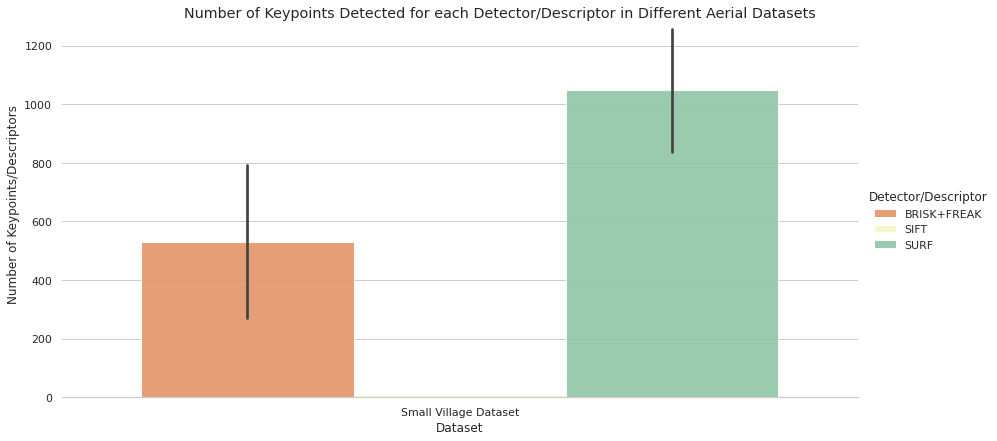

In [59]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_numkey_3, kind="bar",
    x="Dataset", y="Number of Keypoints", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Keypoints/Descriptors")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig(f'drive/MyDrive/Num_Kypoints_8_{Dataset}.png')

In [60]:
df_numkey_3.to_csv(f'drive/MyDrive/Num_Kypoints_3_{Dataset}.csv')

In [ ]:
#rint(len(num_matches_agast))

Total Number of Matches Detected for each Detector+Descriptor

In [61]:
#df_match_15['Number of Total Matches'] =  num_matches_agast + num_matches_akaze + num_matches_brisk + num_matches_daisy + num_matches_fast + num_matches_freak + num_matches_gftt + num_matches_kaze + num_matches_mser + num_matches_orb + num_matches_rootsift + num_matches_sift + num_matches_briefstar + num_matches_superpoint+ num_matches_surf+ num_matches_surfsift
d = {'Dataset': [f'{Dataset}']*(num_detectors*(len_files-1)), 'Number of Total Matches': num_matches_sift + num_matches_surf + num_matches_freak, 'Detector/Descriptor': ['SIFT']*(len_files-1) + ['BRISK+FREAK']*(len_files-1) + ['SURF']*(len_files-1)}
df_match_3 = pd.DataFrame(data=d)
df_match_3['Number of Total Matches'] = df_match_3['Number of Total Matches']/(len_files-1)

Text(0.5, 0.98, 'Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets')

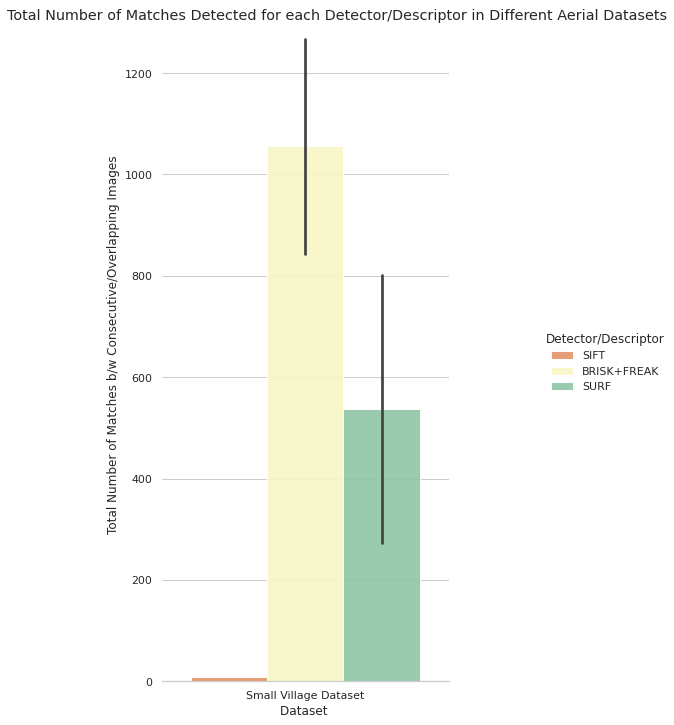

In [62]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_3, kind="bar",
    x="Dataset", y="Number of Total Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset ", "Total Number of Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig(f'drive/MyDrive/Num_Matches_8_{Dataset}.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Matches_16.csv')

Total Number of Good/Robust Matches (NN+Lowe+RANSAC) Detected for each Detector+Descriptor

In [63]:
df_match_3['Number of Good Matches'] =  num_good_matches_sift + num_good_matches_surf + num_good_matches_freak
df_match_3['Number of Good Matches'] = df_match_3['Number of Good Matches']/(len_files-1)

Text(0.5, 0.98, 'Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets')

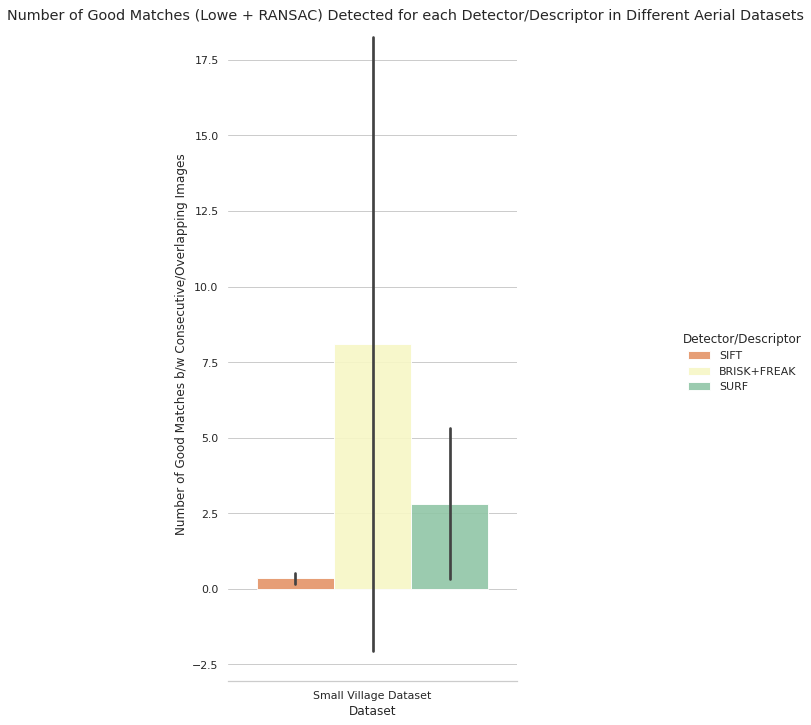

In [64]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_3, kind="bar",
    x="Dataset", y="Number of Good Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Good Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig('drive/MyDrive/Num_Good_Matches_8.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Good_Matches_16.csv')

Recall Rate for each Detector+Descriptor

In [65]:
df_match_3['Recall Rate of Matches'] = df_match_3['Number of Good Matches']/df_match_3['Number of Total Matches']

Text(0.5, 0.98, 'Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

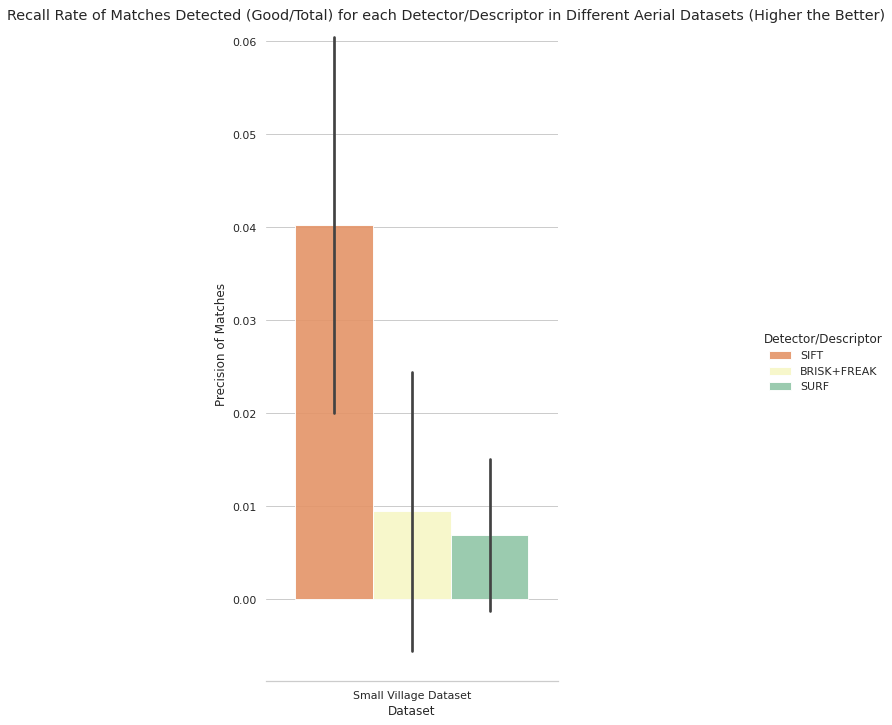

In [66]:
import seaborn as sns
sns.set_theme(style='whitegrid')


g = sns.catplot(
    data=df_match_3, kind="bar",
    x="Dataset", y="Recall Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Precision of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig('drive/MyDrive/Recall_Rate_Matches_8.png')

1-Precision Rate for each Detector+Descriptor

In [67]:
df_match_3['1 - Precision Rate of Matches'] = (df_match_3['Number of Total Matches'] - df_match_3['Number of Good Matches'])/df_match_3['Number of Total Matches']

Text(0.5, 0.98, '1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

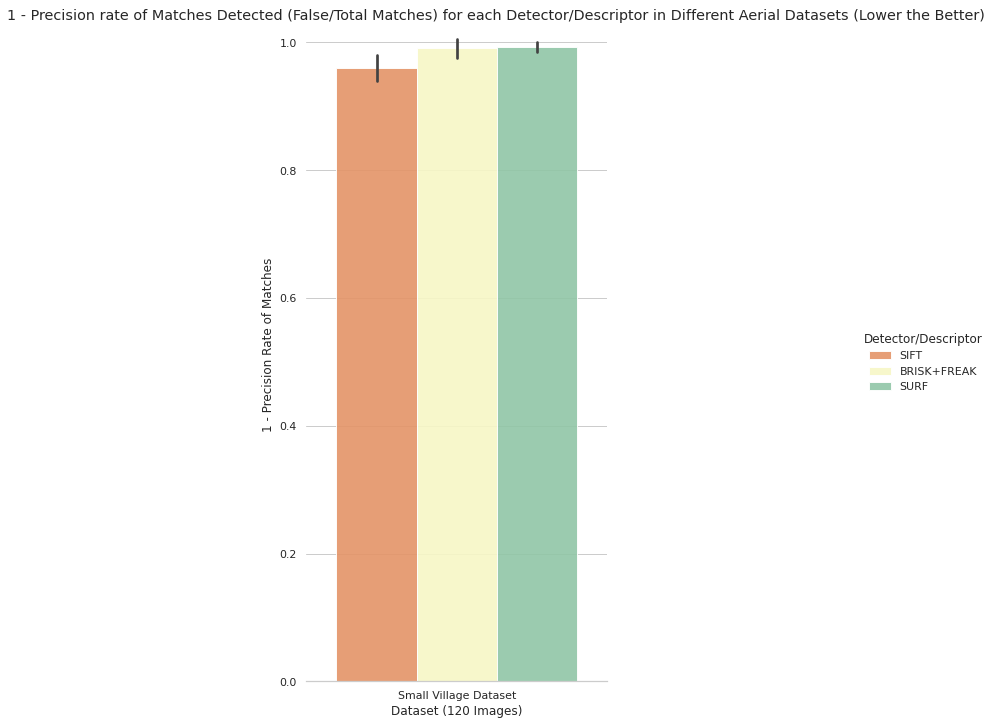

In [68]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_3,kind="bar",
    x="Dataset", y="1 - Precision Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset (120 Images)", "1 - Precision Rate of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
g.savefig('drive/MyDrive/One_minus_Precision_Rate_Matches_8.png')

F-Score for each Detector+Descriptor

In [69]:
df_match_3['F-Score'] = (2* (1 - df_match_3['1 - Precision Rate of Matches']) * df_match_3['Recall Rate of Matches'])/((1 - df_match_3['1 - Precision Rate of Matches']) + df_match_3['Recall Rate of Matches'])

Text(0.5, 0.98, 'F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

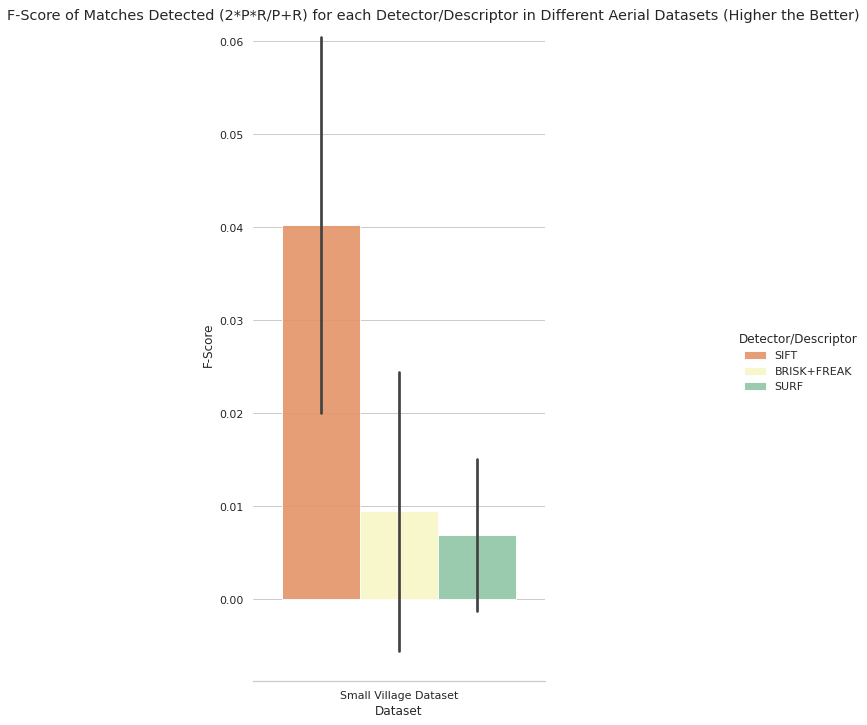

In [70]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_3, kind="bar",
    x="Dataset", y="F-Score", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "F-Score")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig('drive/MyDrive/F_Score_Rate_Matches_8.png')

In [71]:
df_match_3.to_csv('drive/MyDrive/All_metrics_3.csv')

Time for each Detector+Descriptor

In [73]:
d = {'Dataset': [f'{Dataset}']*(num_detectors), 'Time': [time_all[0]] + [time_all[2]] + [time_all[1]], 'Detector/Descriptor': ['BRISK+FREAK']*(1) + ['SURF']*(1) +  ['SIFT']*(1) }
df_time_3 = pd.DataFrame(data=d)

In [74]:
print(df_time_3)

                 Dataset        Time Detector/Descriptor
0  Small Village Dataset  351.669158         BRISK+FREAK
1  Small Village Dataset  948.841670                SURF
2  Small Village Dataset  692.030526                SIFT


Text(0.5, 0.98, 'Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

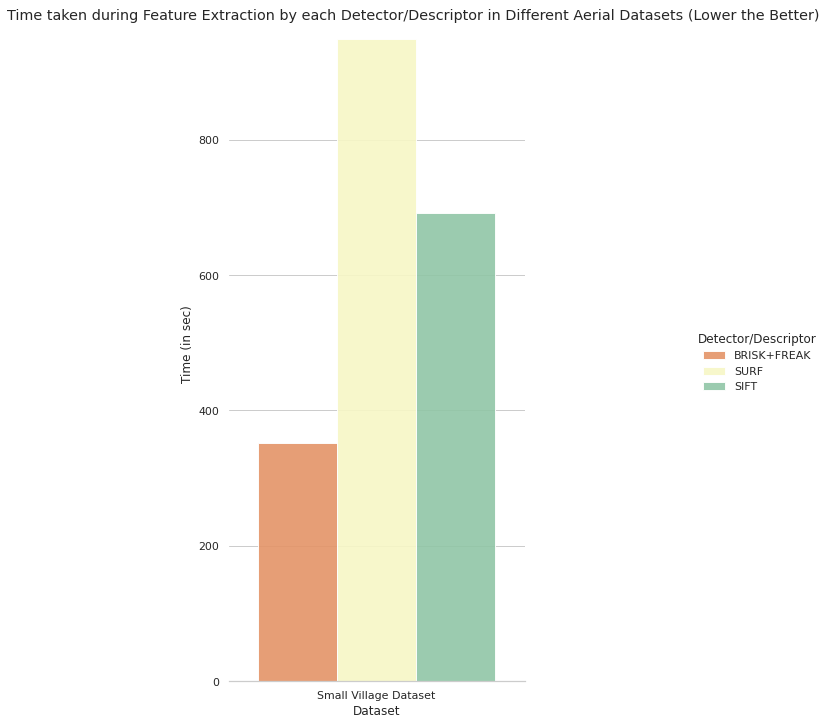

In [75]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_time_3, kind="bar",
    x="Dataset", y="Time", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Time (in sec)")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
g.savefig('drive/MyDrive/Time_8.png')

In [76]:
df_time_3.to_csv('drive/MyDrive/Time_3.csv')

Stitching with CPU